In [ ]:
import git
import time
import pandas as pd
from datetime import datetime, timedelta, date
import io
def is_exists(filename, sha):
    repo = git.Repo("/Users/saksun/work/COVID-19")
    """Check if a file in current commit exist."""
    files = repo.git.show("--pretty=", "--name-only", sha)
    if filename in files:
        return True
    
def get_file_commits(filename, commits):
    file_commits = []
    for commit in commits:
        if is_exists(filename, commit.hexsha):
            file_commits.append(commit)
    return file_commits

def getDataFrame(filename):
    repo = git.Repo("/Users/saksun/work/COVID-19")
    commits = list(repo.iter_commits("master"))
    covid_file_commits = get_file_commits(filename, commits)


    current_time =   datetime(2020, 1, 1)
    prev_commit_datetime = current_time
    prev_commit = covid_file_commits[0]    
    i = 0
    start_date = datetime(2020, 4, 30)
    end_date = datetime(2020,8,19)
    fipsArray =[]
    for file_commit in reversed(covid_file_commits):
        file_commit = repo.commit(file_commit.hexsha)
        commit_datetime_str = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(file_commit.committed_date))
        commit_datetime = datetime.strptime(commit_datetime_str, '%Y-%m-%d %H:%M:%S')
        
        if  ( ((commit_datetime.date() != prev_commit_datetime.date())  
             and prev_commit_datetime.date() > start_date.date()) and commit_datetime.date() < end_date.date())  :
            print("Current commit: ", prev_commit_datetime," : ",
                 prev_commit.message.replace('\n', ' ') )
            # Retrieve a file from the commit tree
            # You can use the path helper to get the file by filename 
            targetfile = prev_commit.tree / filename
            
            with io.BytesIO(targetfile.data_stream.read()) as f:
                if i == 0:
                    US_Covid_df = pd.read_csv(f)
                    US_Covid_df = US_Covid_df.drop(US_Covid_df[US_Covid_df["Province_State"] == "Puerto Rico"].index)
                    
                    US_Covid_df.reset_index(drop=True, inplace=True)
                    i =  i + 1
                else:
                    df = pd.read_csv(f)
                    df = df.drop(df[df["Province_State"] == "Puerto Rico"].index)
                    df.reset_index(drop=True, inplace=True)
                    dd = (prev_commit_datetime.date() -  timedelta(days=1)).strftime('%-m/%-d/%y')
                    i = 0 
                    US_Covid_df[dd] = 0
                    for index, row in US_Covid_df.iterrows():
                        val = df.loc[df['FIPS'] == row["FIPS"]][dd]
                        if type(val) is int:
                            US_Covid_df.at[index,dd] = val
                        else:
                            for v in val.values:
                                US_Covid_df.at[index,dd] = v
                        
                    
        prev_commit= file_commit
        prev_commit_datetime = commit_datetime
    US_Covid_df = US_Covid_df.reset_index()
    return US_Covid_df
#Read US Covid deaths
US_Deaths_df = getDataFrame('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv')
#Read US Covid cases
US_Cases_df = getDataFrame('csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv')


In [12]:
import datetime as dt
import pandas as pd
import  plotly.express as px 
import plotly.graph_objects as go

#US_Deaths_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
#US_Deaths_df = pd.read_csv(US_Deaths_url, error_bad_lines=True)
US_Deaths_df=US_Deaths_df.drop(columns=['index','UID','iso2','iso3','code3','Admin2', 'Country_Region','Lat','Long_','Combined_Key'])
US_Deaths_df=US_Deaths_df.dropna(subset=['FIPS'])
US_Deaths_df=US_Deaths_df.melt(id_vars=["FIPS","Population","Province_State"], 
        var_name="Date", 
        value_name="Value")

#Confirmed_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
#US_Cases_df = pd.read_csv(Confirmed_url, error_bad_lines=True)
US_Cases_df=US_Cases_df.drop(columns=['index','UID','iso2','iso3','code3','Admin2', 'Province_State', 'Country_Region','Lat','Long_','Combined_Key'])
US_Cases_df=US_Cases_df.dropna(subset=['FIPS'])
US_Cases_df=US_Cases_df.melt(id_vars=['FIPS'], 
        var_name="Date", 
        value_name="Value")


US_Deaths_df.iloc[:, 3] = pd.to_datetime(US_Deaths_df.iloc[:, 3])
US_Deaths_df.iloc[:, 3]  = (US_Deaths_df.iloc[:, 3]  - US_Deaths_df['Date'].iloc[0]).dt.days
US_Deaths_df = US_Deaths_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Deaths' })


#US_Deaths_df['Weekly_Deaths'] = US_Deaths_df.groupby(['FIPS', 'Week'])['Cumulative_Deaths'].transform(lambda x: (x.iat[-1] - x.iat[0]))
US_Deaths_df['Weekly_Deaths'] = 0
US_Deaths_df['Weekly_Deaths_Per'] = 0.0
US_Deaths_df['Past_Week_Cumulative_Deaths'] = 0
US_Deaths_df = US_Deaths_df.reset_index()
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Deaths_df['Cumulative_Deaths'].to_numpy()
fipsArray = US_Deaths_df['FIPS'].to_numpy()
i = 0
j = 0
FIPS = 0.0
for index, row in US_Deaths_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_deaths = cdArray[i-7]
        weekly_deaths = row['Cumulative_Deaths'] - previous_cum_deaths
        US_Deaths_df.at[index,'Weekly_Deaths'] =  weekly_deaths
        if previous_cum_deaths  == 0:
          previous_cum_deaths = 1
        US_Deaths_df.at[index, 'Past_Week_Cumulative_Deaths'] = previous_cum_deaths
        US_Deaths_df.at[index, 'Weekly_Deaths_Per'] = (weekly_deaths  * 1.00000) / (previous_cum_deaths * 1.00000)
  else:
    FIPS = countyFIPS
    j = 0 
    US_Deaths_df.at[index,'Weekly_Deaths'] = 0
  i = i + 1
  j = j + 1
    


    
US_Cases_df.iloc[:, 1] = pd.to_datetime(US_Cases_df.iloc[:, 1])
US_Cases_df.iloc[:, 1]  = (US_Cases_df.iloc[:, 1]  - US_Cases_df['Date'].iloc[0]).dt.days
US_Cases_df = US_Cases_df.rename(columns={'Date': 'Days', 'Value':'Cumulative_Cases'})
US_Cases_df['Weekly_Cases'] = 0
US_Cases_df['Weekly_Cases_Per'] = 0.0
US_Cases_df = US_Cases_df.reset_index()
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)
cdArray = US_Cases_df['Cumulative_Cases'].to_numpy()
fipsArray = US_Cases_df['FIPS'].to_numpy()
i = 0
j = 0
for index, row in US_Cases_df.iterrows():
  countyFIPS = row['FIPS']
  if FIPS == countyFIPS: 
    if j > 6 and fipsArray[i-7] == countyFIPS :
        previous_cum_cases = cdArray[i-7]
        weekly_cases = row['Cumulative_Cases'] - previous_cum_cases
        US_Cases_df.at[index,'Weekly_Cases'] =  weekly_cases
        if previous_cum_cases  == 0:
          previous_cum_cases = 1
        US_Cases_df.at[index, 'Weekly_Cases_Per'] = (weekly_cases * 100.0) / (previous_cum_cases * 1.0)
  else:
    FIPS = countyFIPS
    j = 0
    US_Cases_df.at[index,'Weekly_Cases'] = 0
  i = i + 1
  j = j + 1
    
#mobility = pd.read_csv('https://raw.githubusercontent.com/COVIDExposureIndices/COVIDExposureIndices/master/dex_data/county_dex.csv')
#mobility.iloc[:, 1] = pd.to_datetime(mobility.iloc[:, 1])
#mobility.iloc[:, 1]  = (mobility.iloc[:, 1]  - mobility['date'].iloc[0]).dt.days
#mobility = mobility.rename(columns={'date': 'Days'})
#mobility["Days"] = mobility["Days"] + 7


In [13]:
#copy last 7 days to extend prediction for 14 days
max_days = US_Deaths_df['Days'].max()    
US_Deaths_Tail_Rows = US_Deaths_df[US_Deaths_df["Days"] > max_days - 7]
US_Deaths_Tail_Rows["Days"] = US_Deaths_Tail_Rows["Days"] + 7 
US_Deaths_Tail_Rows["Past_Week_Cumulative_Deaths"] = US_Deaths_Tail_Rows["Cumulative_Deaths"] 
US_Deaths_Tail_Rows["Weekly_Deaths"] = 0
US_Deaths_Tail_Rows["Weekly_Deaths_Per"] = 0
US_Deaths_df = pd.concat([US_Deaths_Tail_Rows, US_Deaths_df])
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)

max_days = US_Deaths_df['Days'].max()    
US_Deaths_Tail_Rows = US_Deaths_df[US_Deaths_df["Days"] > max_days - 3]
US_Deaths_Tail_Rows["Days"] = US_Deaths_Tail_Rows["Days"] + 3 
US_Deaths_Tail_Rows["Past_Week_Cumulative_Deaths"] = 0
US_Deaths_Tail_Rows["Weekly_Deaths"] = 0
US_Deaths_Tail_Rows["Weekly_Deaths_Per"] = 0
US_Deaths_df = pd.concat([US_Deaths_Tail_Rows, US_Deaths_df])
US_Deaths_df.sort_values(by=['FIPS','Days'], inplace=True)


max_days = US_Cases_df['Days'].max()    
US_Cases_Tail_Rows = US_Cases_df[US_Cases_df["Days"] > max_days - 10]
US_Cases_Tail_Rows["Days"] = US_Cases_Tail_Rows["Days"] + 10 
US_Cases_Tail_Rows["Cumulative_Cases"] = 0
US_Cases_Tail_Rows["Weekly_Cases"] = 0
US_Cases_Tail_Rows["Weekly_Cases_Per"] = 0
US_Cases_df = pd.concat([US_Cases_Tail_Rows, US_Cases_df])
US_Cases_df.sort_values(by=['FIPS','Days'], inplace=True)


US_Deaths_df.to_csv("usdf.csv")

In [14]:
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [15]:
#load state tests data to combine with cases and deaths
#data is not available for all days, populate zero for missing ones
from datetime import timedelta, date

state_codes = pd.read_csv('https://docs.google.com/spreadsheets/d/1DAqxIYJdagFN85ncoTQO-CbpJLQECvZWt6qwNMQZUkk/export?format=csv')
start_date = date(2020, 1, 22)
end_date = date.today()

state_codes_date_df = pd.DataFrame({'Date': pd.Series([], dtype='str'),
                   'Code': pd.Series([], dtype='str'),
                   'State': pd.Series([], dtype='str')})
for single_date in daterange(start_date, end_date):
  for index, row in state_codes.iterrows():
    state_codes_date_df = state_codes_date_df.append({'Date': single_date.strftime("%Y%m%d"), 'Code' : row["Code"], 'State' : row["State"]}, ignore_index=True)
state_tests = pd.read_csv("https://covidtracking.com/api/v1/states/daily.csv")
convert_dict = {'date': str} 
state_tests = state_tests.astype(convert_dict)
state_tests_df = state_codes_date_df.merge(state_tests[['date','state','positive', 'negative']],how='left', left_on=['Date', 'Code'], right_on=['date', 'state'])
state_tests_df.sort_values(['Date','State'], inplace=True)
state_tests_df.iloc[:, 0] = pd.to_datetime(state_tests_df.iloc[:, 0],format="%Y%m%d")
state_tests_df.iloc[:, 0]  = (state_tests_df.iloc[:, 0] - state_tests_df['Date'].iloc[0]).dt.days
state_tests_df = state_tests_df.rename(columns={'Date': 'Days'})
state_tests_df['Cumulative_Tests'] = state_tests_df['positive'] + state_tests_df ['negative']
state_tests_df = state_tests_df.drop(columns=['date', 'state', 'positive', 'negative'])
state_tests_df.fillna(0, inplace=True)


In [32]:
#Read county variates dataset and combine with FIPS, race, icu_beds dataset
county_covariates= pd.read_csv('https://raw.githubusercontent.com/JieYingWu/COVID-19_US_County-level_Summaries/master/data/counties.csv').dropna(subset=['FIPS'])
county_covariates.FIPS = county_covariates.FIPS.astype('int64')
county_covariates=county_covariates.set_index('FIPS')
age_race_df = pd.read_csv('https://docs.google.com/spreadsheets/d/12GIRONjeNHeKFb3EKpo5r-VvdsnTwwe0iOtKBsnZVM0/export?format=csv')
county_icu_beds= pd.read_csv('https://docs.google.com/spreadsheets/d/13iUBUwRcE91_x9FhsF8Ugcb0_tFauWJF2Z-PSkERDlU/export?format=csv')
FIPS = pd.read_csv('https://docs.google.com/spreadsheets/d/1jUwRaTSJ__3Wp60cZLLox5u55mJTZrShtjEK4d7xTEY/export?format=csv')
covariates = age_race_df.merge(county_covariates, how='inner', left_on=["fips"], right_on=['FIPS'])
covariates = covariates.drop(['STNAME', 'County', 'Unnamed: 0','State', 'Area_Name'], axis=1)
covariates = covariates.merge(county_icu_beds, how='inner', left_on=["fips"], right_on=['fips'])
covariates = covariates.drop(['County','State'], axis=1)
covariates = covariates.fillna(0)
#dropping full NaN counties
#covariates = covariates[covariates['Jul Temp Max / F'].notnull()]
#merge with US FIPS and makue  sure FIPS are only in the US
US_Deaths_df = US_Deaths_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
US_Cases_df = US_Cases_df.merge(FIPS,how='inner', left_on=["FIPS"], right_on=['fips'])
list(covariates.columns) 
covariates = covariates.dropna(axis='columns')
list(covariates.columns) 

covariates=covariates[['fips',
 'TOT_POP',
 '0-9',
 '0-9 y/o % of total pop',
 '10-19',
 '10-19 y/o % of total pop',
 '20-29',
 '20-29 y/o % of total pop',
 '30-39',
 '30-39 y/o % of total pop',
 '40-49',
 '40-49 y/o % of total pop',
 '50-59',
 '50-59 y/o % of total pop',
 '60-69',
 '60-69 y/o % of total pop',
 '70-79',
 '70-79 y/o % of total pop',
 '80+',
 '80+ y/o % of total pop',
 'White-alone pop',
 '% White-alone',
 'Black-alone pop',
 '% Black-alone',
 'Native American/American Indian-alone pop',
 '% NA/AI-alone',
 'Asian-alone pop',
 '% Asian-alone',
 'Hawaiian/Pacific Islander-alone pop',
 '% Hawaiian/PI-alone',
 'Two or more races pop',
 '% Two or more races',
 'POP_ESTIMATE_2018',
 'N_POP_CHG_2018',
 'GQ_ESTIMATES_2018',
 'R_birth_2018',
 'R_death_2018',
 'R_NATURAL_INC_2018',
 'R_INTERNATIONAL_MIG_2018',
 'R_DOMESTIC_MIG_2018',
 'R_NET_MIG_2018',
 'Less than a high school diploma 2014-18',
 'High school diploma only 2014-18',
 "Some college or associate's degree 2014-18",
 "Bachelor's degree or higher 2014-18",
 'Percent of adults with less than a high school diploma 2014-18',
 'Percent of adults with a high school diploma only 2014-18',
 "Percent of adults completing some college or associate's degree 2014-18",
 "Percent of adults with a bachelor's degree or higher 2014-18",
 'POVALL_2018',
 'PCTPOVALL_2018',
 'PCTPOV017_2018',
 'PCTPOV517_2018',
 'MEDHHINC_2018',
 'CI90LBINC_2018',
 'CI90UBINC_2018',
 'Civilian_labor_force_2018',
 'Employed_2018',
 'Unemployed_2018',
 'Unemployment_rate_2018',
 'Median_Household_Income_2018',
 'Med_HH_Income_Percent_of_State_Total_2018',
 'Jan Precipitation / inch',
 'Feb Precipitation / inch',
 'Mar Precipitation / inch',
 'Apr Precipitation / inch',
 'May Precipitation / inch',
 'Jun Precipitation / inch',
 'Jul Precipitation / inch',
 'Jan Temp AVG / F',
 'Feb Temp AVG / F',
 'Mar Temp AVG / F',
 'Apr Temp AVG / F',
 'May Temp AVG / F',
 'Jun Temp AVG / F',
 'Jul Temp AVG / F',
 'Active Physicians per 100000 Population 2018 (AAMC)',
 'Total Active Patient Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active Patient Care Primary Care Physicians per 100000 Population 2018 (AAMC)',
 'Active General Surgeons per 100000 Population 2018 (AAMC)',
 'Active Patient Care General Surgeons per 100000 Population 2018 (AAMC)',
 'Total nurse practitioners (2019)',
 'Total physician assistants (2019)',
 'Total Hospitals (2019)',
 'Internal Medicine Primary Care (2019)',
 'Family Medicine/General Practice Primary Care (2019)',
 'Total Specialist Physicians (2019)',
 'ICU Beds_x',
 'Total Population',
 'Population Aged 60+',
 'Percent of Population Aged 60+']]
 
#print(covariates)

In [33]:
US_Deaths_Cases_df['Province_State'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia',
       'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
       'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan',
       'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska',
       'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
       'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [31]:
#build prior - 1 ,2 ,3 week(s) cases and deaths as features

US_Cases_Prior_Fourteen_df = US_Cases_df.copy() 
US_Cases_Prior_Fourteen_df["Days"] = US_Cases_df["Days"] + 14
US_Cases_Prior_Fourteen_df.rename(columns = {'Weekly_Cases_Per':'Two_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Two_Week_Prior_Weekly_Cases'}, inplace = True)
US_Cases_Prior_TwentyOne_df = US_Cases_df.copy() 
US_Cases_Prior_TwentyOne_df["Days"] = US_Cases_df["Days"] + 21
US_Cases_Prior_TwentyOne_df.rename(columns = {'Weekly_Cases_Per':'Three_Week_Prior_Weekly_Cases_Per', 'Weekly_Cases':'Three_Week_Prior_Weekly_Cases'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_df
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_TwentyOne_df[['Three_Week_Prior_Weekly_Cases_Per', 'Three_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Cases_Prior_Fourteen_df[['Two_Week_Prior_Weekly_Cases_Per', 'Two_Week_Prior_Weekly_Cases', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])

US_Deaths_Prior_TwentyOne_df = US_Deaths_df.copy()
US_Deaths_Prior_TwentyOne_df["Days"] = US_Deaths_df["Days"] + 21
US_Deaths_Prior_TwentyOne_df.rename(columns = {'Weekly_Deaths_Per':'Three_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Three_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_TwentyOne_df[['Three_Week_Prior_Weekly_Deaths_Per', 'Three_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])

US_Deaths_Prior_Fourteen_df = US_Deaths_df.copy()
US_Deaths_Prior_Fourteen_df["Days"] = US_Deaths_df["Days"] + 14
US_Deaths_Prior_Fourteen_df.rename(columns = {'Weekly_Deaths_Per':'Two_Week_Prior_Weekly_Deaths_Per', 'Weekly_Deaths':'Two_Week_Prior_Weekly_Deaths'}, inplace = True)
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(US_Deaths_Prior_Fourteen_df[['Two_Week_Prior_Weekly_Deaths_Per', 'Two_Week_Prior_Weekly_Deaths', 'FIPS', 'Days']], how='left', left_on=['FIPS', "Days"], right_on=['FIPS', 'Days'])
US_Deaths_Cases_df.to_csv("udc1.csv")

In [19]:
#mobility["county"] = mobility["county"].astype("float")
#US_Deaths_Cases_df = US_Deaths_Cases_df.merge(state_tests_df, how='inner', left_on=['Province_State', "Days"], right_on=['State', 'Days'])
#US_Deaths_Cases_df = US_Deaths_Cases_df.merge(mobility[['dex', 'num_devices','county','Days']], how='left', left_on=['FIPS', "Days"], right_on=['county', 'Days'])

covariates_merged = covariates.merge(US_Deaths_Cases_df[[
                                                        'Three_Week_Prior_Weekly_Cases_Per',
                                                        'Three_Week_Prior_Weekly_Cases',
                                                        'Two_Week_Prior_Weekly_Cases_Per',
                                                        'Two_Week_Prior_Weekly_Cases',
                                                        'Three_Week_Prior_Weekly_Deaths_Per',
                                                        'Three_Week_Prior_Weekly_Deaths',
                                                        'Two_Week_Prior_Weekly_Deaths_Per',
                                                        'Two_Week_Prior_Weekly_Deaths',                                                        
                                                         'FIPS', 'Days']], how='inner', left_on=["fips"], right_on=['FIPS'])
#dropping NaN columns
covariate_merged = covariates_merged.dropna(axis='columns')
US_Deaths_Cases_df =  US_Deaths_Cases_df.dropna(axis='columns')
fips_state=age_race_df[['STNAME','fips']]
US_Deaths_Cases_df = US_Deaths_Cases_df.merge(fips_state, how='inner', left_on=["FIPS"], right_on=['fips'])
US_Deaths_Cases_df = US_Deaths_Cases_df.drop(columns=['index'])
#pd.set_option('display.max_rows', None)
#corr=covariate_merged.corr()
#print(corr[['Cumulative_Deaths','Daily_Deaths']])

In [29]:
US_Deaths_Cases_df['STNAME'].unique()

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'North Carolina',
       'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania',
       'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee',
       'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
       'West Virginia', 'Wisconsin', 'Wyoming'], dtype=object)

In [21]:
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.metrics import r2_score
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
import xgboost as xgb
from datetime import datetime
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit

warnings.filterwarnings("ignore", category=ConvergenceWarning)
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

min_day=US_Deaths_Cases_df['Days'].min()
max_day=US_Deaths_Cases_df['Days'].max()
countyFIPS = US_Deaths_Cases_df["FIPS"].unique()

num_weeks=int((max_day-min_day)/7)
print("min_day: " , min_day, " max day: ", max_day, " number of weeks : " , num_weeks)
#prediction_days_arr = [7,14,21,28]
#prediction_days = 7   # one week  train , tune and forecast
#prediction_days = 14 # two weks train , tune and forecast
prediction_days = 21 # three weks train , tune and forecast
#prediction_days = 28 # four weeks train , tune and forecast
day_offset=173
best_fit_scores = pd.DataFrame(columns=["Week Duration", "Best_Parameters", "Best_Score", "Predict_R2_Score"])
predicted_df_all_days = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths' 'Predicted_Cumulative_Deaths'])
#i = 0
#iteration = 0 
index = 0
#tune_forecast_rscores = pd.DataFrame( columns=['week', 'tune_alpha', 'tune_max_r2_score', 'forecast_r2_score'])
#weekly_alpha_rscores = pd.DataFrame( columns=['week', 'alpha', 'r2_score'])
#predict_week_rscores = pd.DataFrame( columns=['week', 'r2_score'])

train_start_week_day = day_offset
train_end_week_day = train_start_week_day + prediction_days
tune_start_week_day = train_end_week_day
tune_end_week_day = train_end_week_day + prediction_days
predict_start_week_day = train_end_week_day 
predict_end_week_day = predict_start_week_day + 14
  

for week_num in range(num_weeks):
    if predict_end_week_day > max_day:
        break
    predict_start_date = (covid_start_date + timedelta(days=predict_start_week_day)).date()
    predict_end_date =  (covid_start_date + timedelta(days=predict_end_week_day)).date()
    print("train:", train_start_week_day ,":", train_end_week_day, 
        " predict:" , predict_start_week_day, ":",  predict_end_week_day,
        " predict start date: ",  predict_start_date,
        " predict end date: ",  predict_end_date)
    print 
    #print ("training week number: " , week_num+1)
    #********************TRAIN MODEL ************************ 
    #train with all coutnies variates for one  week  and predict for LA county cumulative deaths
    train_week = pd.Series(range(train_start_week_day,train_end_week_day))
    #print ("training week series :" , train_week.array)
    covariates_train_week = covariates_merged.loc[(covariates_merged['Days'].isin(train_week))] 
    US_Weekly_Deaths = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(train_week))].iloc[:, 5]  
    if len(US_Weekly_Deaths) == 0:
        continue
   
    X_train = covariates_train_week
    Y_train = US_Weekly_Deaths
    #reg = LassoCV(cv=5, random_state=0).fit(X_train, Y_train)
    xgbReg = xgb.XGBRegressor()

    parameters = {
          'objective':['reg:squarederror'],
          'learning_rate': [0.01, 0.05, 0.08], #so called `eta` value
          'max_depth': [3,4,5],
          'min_child_weight': [1,2],
          'subsample': [0.8],
          'colsample_bytree' : [0.8],
          'n_estimators': [ 100,200]}
    tscv = TimeSeriesSplit(n_splits=4)
    xgb_grid = GridSearchCV(xgbReg,
                    parameters,
                    cv = tscv,
                    n_jobs = 4,
                    scoring = 'r2',
                    verbose=True)

    xgb_grid.fit(X_train,Y_train)


    print(xgb_grid.best_score_)
    print(xgb_grid.best_params_)
    results = xgb_grid.cv_results_
    predict_week = pd.Series(range(predict_start_week_day, predict_end_week_day ))
    #print ("predicting next week series :" , predict_week.array)
  
    X_predict_week = covariates_merged.loc[(covariates_merged['Days'].isin(predict_week))]
    predict_week_df = US_Deaths_Cases_df.loc[(US_Deaths_Cases_df['Days'].isin(predict_week))]
    Y_actual_predict_week = predict_week_df.iloc[:,5]
    #best_reg.fit(X_tune_week, Y_actual_tune_week)
    Y_predict_week = xgb_grid.best_estimator_.predict(X_predict_week)
    predict_score = r2_score(Y_actual_predict_week, Y_predict_week)
    print(week_num , ":", predict_score)
    
  
    predicted_df = pd.DataFrame(columns=['State','FIPS', 'Forecast_Day','Days','Predicted_Weekly_Deaths','Predicted_Cumulative_Deaths'])
    predicted_df["State"] = predict_week_df["STNAME"]
    predicted_df["FIPS"] = predict_week_df["FIPS"]
    predicted_df["Days"] = predict_week_df["Days"]
    predicted_df["Forecast_Day"] =  (covid_start_date + timedelta(days=(predict_start_week_day-1))).strftime("%Y-%m-%d")
    predicted_df["Predicted_Weekly_Deaths"] = Y_predict_week
    predicted_df["Predicted_Cumulative_Deaths"] = predicted_df["Predicted_Weekly_Deaths"] + predict_week_df["Past_Week_Cumulative_Deaths"]
    best_fit_scores.loc[index] = [str(predict_start_date) + ' - '  + str(predict_end_date), xgb_grid.best_params_, xgb_grid.best_score_,  predict_score]
    
    pwcdArray = predicted_df["Predicted_Cumulative_Deaths"].to_numpy()
    fipsArray = predicted_df['FIPS'].to_numpy()
    j = 0
    i = 0 
    FIPS = 0.0
    for index, row in predicted_df.iterrows():
        countyFIPS = row['FIPS']
        if  FIPS == countyFIPS:
            if (j > 6) and  fipsArray[i-7] == countyFIPS:
                past_week_cum_deaths = pwcdArray[i-7]
                predicted_df.at[index, 'Predicted_Cumulative_Deaths'] = (row["Predicted_Weekly_Deaths"]) + past_week_cum_deaths
        else:
            FIPS = row['FIPS']
            j = 0 
        i = i + 1
        j = j + 1
        

    predicted_df_all_days = pd.concat([predicted_df_all_days, predicted_df])

    train_start_week_day = train_start_week_day + 7
    train_end_week_day = train_end_week_day + 7
    predict_start_week_day = train_end_week_day
    predict_end_week_day = train_end_week_day + 14
    index = index + 1
   
predicted_df_all_days.to_csv("predicted_all_days.csv", index=False)

min_day:  0  max day:  217  number of weeks :  31
train: 173 : 194  predict: 194 : 208  predict start date:  2020-08-03  predict end date:  2020-08-17
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.8min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 13.4min finished


0.6820668438275788
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
0 : 0.8616623599231412
train: 180 : 201  predict: 201 : 215  predict start date:  2020-08-10  predict end date:  2020-08-24
Fitting 4 folds for each of 36 candidates, totalling 144 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done 144 out of 144 | elapsed: 13.5min finished


0.680615486189957
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200, 'objective': 'reg:squarederror', 'subsample': 0.8}
1 : 0.007404386810222041


In [22]:
best_fit_scores[["Best_Score", "Predict_R2_Score"]] = best_fit_scores[["Best_Score", "Predict_R2_Score"]].apply(pd.to_numeric)
best_fit_scores.to_csv('scores_timeseries_latest_no_fips_all_states.csv', index=False)

In [274]:
predicted_df_all_days

,State,FIPS,Forecast_Day,Days,Predicted_Weekly_DeathsPredicted_Cumulative_Deaths,Predicted_Weekly_Deaths,Predicted_Cumulative_Deaths
96,Alabama,1001.0,2020-04-26,96,NaN,0.5,1.5
97,Alabama,1001.0,2020-04-26,97,NaN,0.5,1.5
98,Alabama,1001.0,2020-04-26,98,NaN,0.5,2.5
99,Alabama,1001.0,2020-04-26,99,NaN,0.5,2.5
100,Alabama,1001.0,2020-04-26,100,NaN,0.5,2.5
...,...,...,...,...,...,...,...
676938,Wyoming,56045.0,2020-08-09,210,NaN,0.1,1.3
676939,Wyoming,56045.0,2020-08-09,211,NaN,0.1,1.3
676940,Wyoming,56045.0,2020-08-09,212,NaN,0.1,1.3
676941,Wyoming,56045.0,2020-08-09,213,NaN,0.1,0.3


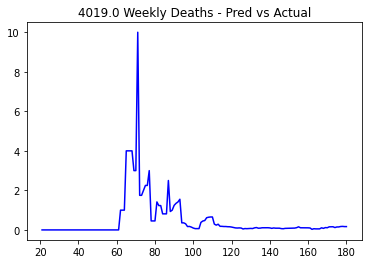

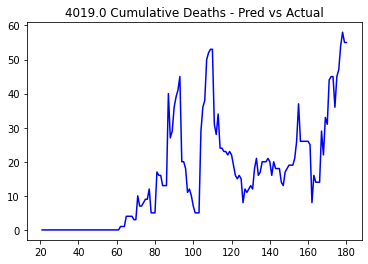

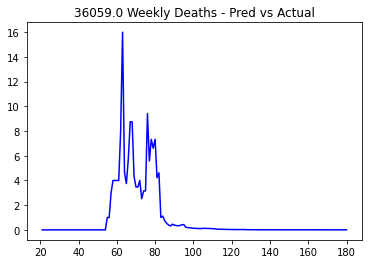

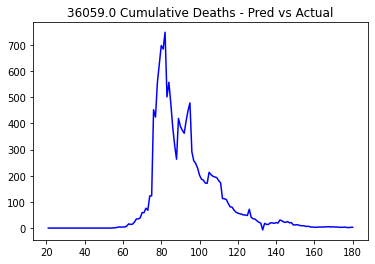

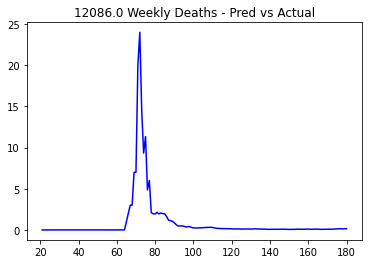

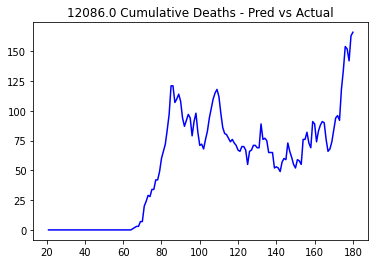

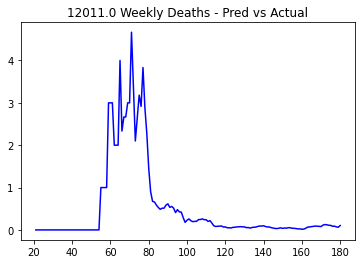

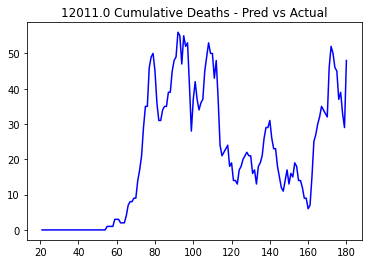

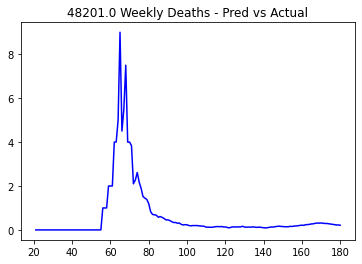

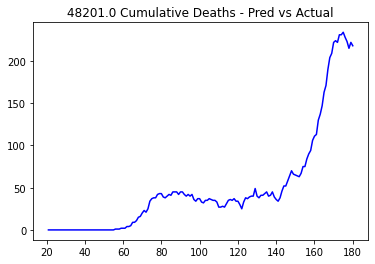

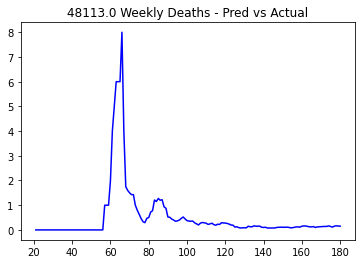

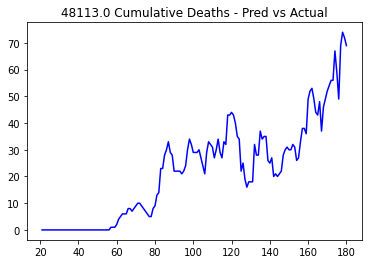

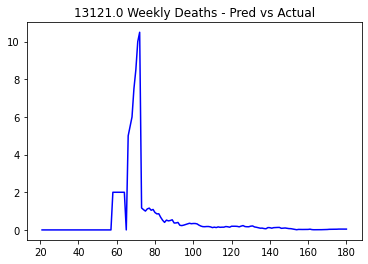

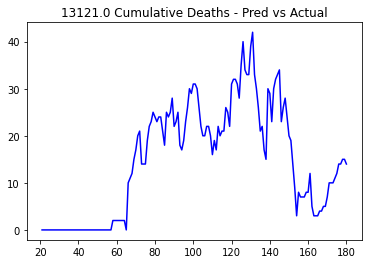

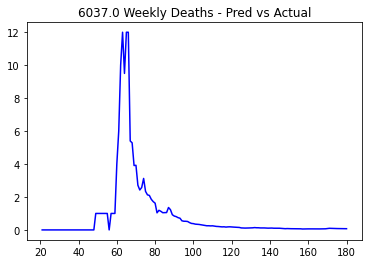

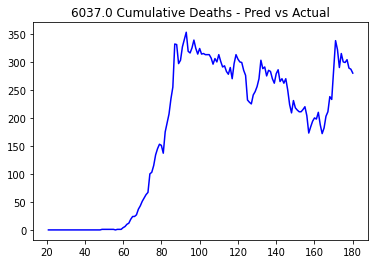

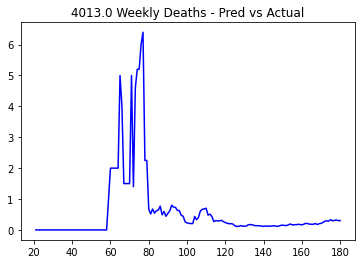

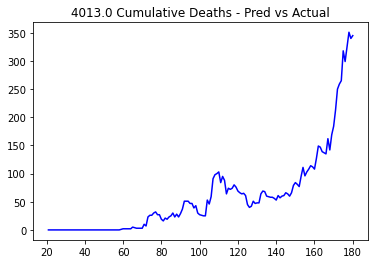

In [275]:
import matplotlib.pyplot as plt
%matplotlib inline
FIPS = [ 4019.0,36059.0, 12086.0, 12011.0, 48201.0,48113.0,13121.0,6037.0,  4013.0]
forecast_days = ['2020-05-17', '2020-05-31', '2020-06-14','2020-06-28']

for f in FIPS:
        
    #predicted_df_90 = predicted_df_all_days[(predicted_df_all_days["FIPS"] == f) & (predicted_df_all_days["Forecast_Day"].isin(forecast_days))]

    Deaths_Cases_df = US_Deaths_Cases_df[(US_Deaths_Cases_df["FIPS"] == f) &  (US_Deaths_Cases_df["Days"] >= 21) &(US_Deaths_Cases_df["Days"] <= 180)]

    x = Deaths_Cases_df["Days"]
    #z= predicted_df_90["Predicted_Weekly_Deaths"]
    y = Deaths_Cases_df["Weekly_Deaths_Per"]
    plt.title(str(f) +" Weekly Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
    #plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_Weekly_Deaths.png", dpi=100)   
    plt.show()

    x = Deaths_Cases_df["Days"]
    #z= predicted_df_90["Predicted_Cumulative_Deaths"]
    y = Deaths_Cases_df["Weekly_Deaths"]
    plt.title(str(f) +" Cumulative Deaths - Pred vs Actual")
    plt.plot(x, y, "-b", label="actual")
   # plt.plot(x, z, "-r", label="predicted")
    plt.savefig(str(f) + "_X_Cumulative_Deaths.png", dpi=100)
    plt.show()


In [23]:
from datetime import datetime

predicted_df_all_days = pd.read_csv("predicted_all_days.csv")
covid_start_date = datetime.strptime("01/22/20", "%m/%d/%y")

state_predicted_deaths = predicted_df_all_days.groupby(['State', 'Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()
state_to_fips=pd.read_csv('https://docs.google.com/spreadsheets/d/1w4sHgYifJV-C8J1WV5rpTzEFLuyZ5ESp8r_1ck-9hlA/export?format=csv')
state_predicted_deaths = state_predicted_deaths.merge(state_to_fips, how='left', left_on=['State'], right_on=['Name'])
state_predicted_deaths=state_predicted_deaths.drop(columns=['Name'])
country_predicted_deaths = predicted_df_all_days.groupby(['Days', 'Forecast_Day'], as_index=False)[["Predicted_Cumulative_Deaths"]].sum()

state_predicted_deaths=state_predicted_deaths[['State','FIPS','Days','Forecast_Day','Predicted_Cumulative_Deaths']]
iteration = 0  
forecast_dates = country_predicted_deaths["Forecast_Day"].unique()
for forecast_date in forecast_dates:
  print(forecast_date)  
  covid_hub_predicted_deaths = pd.DataFrame(columns=['forecast_date','target', 'target_end_date','location', 'location_name','type', 'quantile', 'value']) 
  filename = "forecast-hub/data-processed/MIT_Sak/{}-MIT-Sak.csv".format(forecast_date)
  cp_detahs_forecast= country_predicted_deaths[country_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in cp_detahs_forecast.iterrows():

      covid_hub_predicted_deaths.loc[iteration,"location"] = 'US'
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = 'US'
      #predicted_df["FIPS"] = predict_week_df["FIPS"]
      #predicted_df["Days"] = predict_week_df["Days"]
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0

      iteration = iteration + 1
  state_predicted_deaths_forecast = state_predicted_deaths[state_predicted_deaths["Forecast_Day"] == forecast_date]
  for index, row in state_predicted_deaths_forecast.iterrows():
      covid_hub_predicted_deaths.loc[iteration,"location"] = str(row["FIPS"]).zfill(2)
      covid_hub_predicted_deaths.loc[iteration,"location_name"] = row["State"]
   
      target_date = (covid_start_date + timedelta(days=row["Days"]))
      forecast_day =  (datetime.strptime(row["Forecast_Day"],"%Y-%m-%d") - covid_start_date).days
      days_from = str(row["Days"] - forecast_day)
   
      covid_hub_predicted_deaths.loc[iteration,"target"] = days_from + " day ahead cum death"
      covid_hub_predicted_deaths.loc[iteration,"target_end_date"] = target_date.strftime("%Y-%m-%d")
      covid_hub_predicted_deaths.loc[iteration,"forecast_date"] =  row["Forecast_Day"]
      covid_hub_predicted_deaths.loc[iteration,"type"] ="point"
      covid_hub_predicted_deaths.loc[iteration,"quantile"] ="NA"
      if row["Predicted_Cumulative_Deaths"] >= 0:
        covid_hub_predicted_deaths.loc[iteration,"value"] = row["Predicted_Cumulative_Deaths"]
      else:
        covid_hub_predicted_deaths.loc[iteration,"value"] = 0
      iteration = iteration + 1
  
  covid_hub_predicted_deaths.to_csv(filename,index = False)
  #files.download(filename)


2020-08-02
2020-08-09


In [24]:
import evaluate_models
from datetime import datetime, timedelta
from os import listdir
from os.path import isfile, join
files = listdir('forecast-hub/data-processed/MIT_Sak')
files.sort()
for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=5) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/one-week")


running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-04
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-04
out_dir   : eval/one-week
use_point: True
use_cumulative_deaths: False
Days ahead: 5
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv', '2020-08-02-Auquan-SEIR.csv', '2020-08-09-Auquan-SEIR.csv']
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv', '2020-07-19-CDDEP-SEIR_MCMC.csv', '2020-07-26-CDDEP-SEIR_MCMC.csv', '2020-08-02-CDDEP-SEIR_MCMC.csv', '2020-08-09-CDDEP-SEIR_MCMC.csv']
CEID-Walk - No files within range: ['2020-08-09-CEID-Walk.csv']
CMU-TimeSeries - No files within range: ['2020-07-20-CMU-TimeSeries.csv', '

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 7634
Loading model projections
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 18.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-04 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-04 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
MIT_Sak
Max projection date: 2020-04-05 - 0.9 weeks ahead
* No median data
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 50
Begin Evaluation
Number of locations with projections:
Baseline              52
Baseline_0.98         52


STH-3PU - No files within range: ['2020-06-11-STH-3PU.csv', '2020-06-12-STH-3PU.csv', '2020-06-13-STH-3PU.csv', '2020-06-14-STH-3PU.csv', '2020-06-15-STH-3PU.csv', '2020-06-16-STH-3PU.csv', '2020-06-17-STH-3PU.csv', '2020-06-18-STH-3PU.csv', '2020-06-19-STH-3PU.csv', '2020-06-20-STH-3PU.csv', '2020-06-21-STH-3PU.csv', '2020-06-22-STH-3PU.csv', '2020-06-23-STH-3PU.csv', '2020-06-24-STH-3PU.csv', '2020-06-25-STH-3PU.csv', '2020-06-26-STH-3PU.csv', '2020-06-27-STH-3PU.csv', '2020-06-28-STH-3PU.csv', '2020-06-29-STH-3PU.csv', '2020-06-30-STH-3PU.csv', '2020-07-01-STH-3PU.csv', '2020-07-02-STH-3PU.csv', '2020-07-03-STH-3PU.csv', '2020-07-04-STH-3PU.csv', '2020-07-05-STH-3PU.csv', '2020-07-06-STH-3PU.csv', '2020-07-07-STH-3PU.csv', '2020-07-08-STH-3PU.csv', '2020-07-09-STH-3PU.csv', '2020-07-10-STH-3PU.csv', '2020-07-11-STH-3PU.csv', '2020-07-12-STH-3PU.csv', '2020-07-13-STH-3PU.csv', '2020-07-14-STH-3PU.csv', '2020-07-15-STH-3PU.csv', '2020-07-16-STH-3PU.csv', '2020-07-17-STH-3PU.csv', '202

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 12721
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
LANL-GrowthRate
Max projection date: 2020-05-23 - 6.7 weeks ahead
Num unique lo

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 14258
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 16.1 weeks ahead
* No median data
Num uniq

------------------------
State-by-state mean absolute errors:
                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -18.9     0.7     -2.7      -1.6      -249.7       5.7       -219.1     -14.0                 -17.0    -81.3    -49.7     4.3   -1.4    -156.7    -16.9 -13.3     0.1      -2.4   
Baseline_0.98        -20.9     0.6     -5.3      -2.0      -261.9      -0.5       -234.4     -14.9                 -18.2    -91.3    -59.0     4.1   -2.1    -175.3    -25.9 -14.2    -1.3      -4.6   
COVIDhub-baseline    -13.0     2.0    -16.0      -2.0      -219.0     -22.0       -263.0     -15.0                 -18.0    -67.0    -16.0     4.0   -3.0    -149.0     -1.0 -20.0     4.0      -4.0   
COVIDhub-ensemble     -0.8     2.2     -4.8      -0.6      -232.0     -15.1        -52.2     -15.1                 -15.8     48.4     44.4

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 13089
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 15.1 weeks ahead
* No median

                   count  mean  median   std  min  25%   75%    max
Baseline            51.0  52.6    10.4 146.7  0.1  3.6  40.9  999.7
Baseline_0.98       51.0  54.2    14.4 122.1  0.2  4.6  47.2  785.2
IHME-CurveFit       51.0  65.5    16.8 152.1  0.0  6.8  46.1  974.2
YYG-ParamSearch     51.0  68.3    17.2 144.9  0.2  4.0  55.1  768.8
LANL-GrowthRate     51.0  92.4    15.6 280.4  0.7  7.4  51.6 1927.6
COVIDhub-baseline   51.0 136.1    10.0 663.0  0.0  5.0  32.0 4727.0
MIT_Sak             51.0 149.4    42.6 245.5  0.9 27.0 128.0 1218.7
CU-select           51.0 164.8    34.0 431.9  1.0 10.5 109.5 2771.0
UT-Mobility         51.0 175.9    17.7 813.6  0.9  4.4  51.6 5777.3
MOBS-GLEAM_COVID    51.0 219.1    49.4 419.2  2.6 17.3 188.9 2176.8
Saved to: eval/one-week/2020-04-25/2020-04-20_2020-04-25_states_abs_errs.csv
----------------------
Mean/median ranks:
COVIDhub-baseline   3.2
UT-Mobility         3.6
YYG-ParamSearch     3.6
IHME-CurveFit       3.8
LANL-GrowthRate     4.1
CU-select    

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 12136
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locatio

US                               66865.0               nan          55828.0          69410.4  66886.6        63643.9           63029.3              nan      58719.5          66041.3  
Saved to: eval/one-week/2020-05-02/projections_2020-04-27_2020-05-02.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                 -15.9     0.0     23.0     -10.7        14.7      85.7        171.1      -2.6                   8.3    -31.0    -64.7     1.4    2.3     -74.9   -200.9 -20.1     3.0   
Baseline_0.98            -18.4     0.0     19.2     -11.2        -8.2      74.5        137.9      -4.8                   4.9    -43.6    -74.3     1.3    1.8    -101.7   -211.3 -21.9     1.8   
COVIDhub-baseline        -23.0     0.0     36.0     -14.0        58.0     147.0        208.0     -1

UA-EpiCovDA - No files within range: ['2020-05-23-UA-EpiCovDA.csv', '2020-05-31-UA-EpiCovDA.csv', '2020-06-07-UA-EpiCovDA.csv', '2020-06-14-UA-EpiCovDA.csv', '2020-06-19-UA-EpiCovDA.csv', '2020-06-21-UA-EpiCovDA.csv', '2020-06-28-UA-EpiCovDA.csv', '2020-07-05-UA-EpiCovDA.csv', '2020-07-12-UA-EpiCovDA.csv', '2020-07-19-UA-EpiCovDA.csv', '2020-07-26-UA-EpiCovDA.csv', '2020-08-02-UA-EpiCovDA.csv', '2020-08-09-UA-EpiCovDA.csv']
UCLA-SuEIR - Found file: 2020-05-01-UCLA-SuEIR.csv
UCM_MESALab-FoGSEIR - No files within range: ['2020-07-26-UCM_MESALab-FoGSEIR.csv', '2020-08-02-UCM_MESALab-FoGSEIR.csv', '2020-08-09-UCM_MESALab-FoGSEIR.csv']
UChicago-CovidIL - No files within range: ['2020-05-05-UChicago-CovidIL.csv', '2020-05-11-UChicago-CovidIL.csv', '2020-05-18-UChicago-CovidIL.csv']
UChicago-CovidIL_100 - No files within range: ['2020-05-05-UChicago-CovidIL_100.csv', '2020-05-11-UChicago-CovidIL_100.csv', '2020-05-18-UChicago-CovidIL_100.csv']
UChicago-CovidIL_10_+ - No files within range: ['

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-04.csv
Incident US deaths: 11185
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-27 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-30 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-select
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-05-18 - 2

Saved to: eval/one-week/2020-05-09/projections_2020-05-04_2020-05-09.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                 -39.1    -1.0    -95.4       9.4       -50.1       7.0        -57.1       4.9                   2.6    -75.4     10.7     2.6    3.9    -143.9     29.4 -11.4   -10.3   
Baseline_0.98            -42.1    -1.0    -99.1       8.4       -70.6       0.6        -78.5       2.5                  -0.5    -88.1     -0.5     2.4    3.5    -172.4     16.1 -14.2   -11.2   
COVIDhub-baseline        -23.0    -1.0   -145.0       8.0       -16.0      13.0         75.0       3.0                   4.0    -42.0     44.0     2.0    5.0    -106.0     68.0 -14.0   -10.0   
COVIDhub-ensemble        -39.3     1.2    -99.9       1.5        20.7      44.3         1

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-11.csv
Incident US deaths: 9084
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (pos

Saved to: eval/one-week/2020-05-16/2020-05-11_2020-05-16_states_abs_errs.csv
----------------------
Mean/median ranks:
YYG-ParamSearch         4.7
LANL-GrowthRate         5.3
COVIDhub-ensemble       5.5
UMass-MechBayes         6.0
UT-Mobility             6.3
COVIDhub-baseline       6.6
IHME-CurveFit           7.0
CU-select               7.1
UCLA-SuEIR              7.2
MOBS-GLEAM_COVID        7.6
MIT_Sak_State           8.5
CovidAnalytics-DELPHI   9.3
MIT_Sak                 9.7
Name: mean_rank, dtype: float64
Saved to: eval/one-week/2020-05-16/2020-05-11_2020-05-16_states_mean_ranks.csv
running evaluation for proj_date:  2020-05-18  eval_date:  2020-05-23
Forecast hub dir: forecast-hub
proj_date: 2020-05-18
eval_date: 2020-05-23
out_dir   : eval/one-week
use_point: True
use_cumulative_deaths: False
Days ahead: 5
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - Found file: 2020-05-18-Auquan-SEIR.csv
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', 

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-19.csv
Incident US deaths: 7547
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-11 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 

                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR              110.0     2.0     43.0      24.0       283.0     120.0         62.0      44.0                  41.0    164.0     97.0     4.0   13.0     602.0    214.0  48.0    56.0   
Baseline                  20.4     0.0      2.4     -11.0       -47.9      97.1        111.0      27.1                   7.4    -44.0    -37.1     0.0   -0.9      47.9     -4.7 -21.3     8.0   
Baseline_0.98             16.5     0.0     -3.6     -11.3       -69.7      87.0         92.6      24.3                   4.9    -54.5    -45.7     0.0   -1.1      15.7    -14.9 -24.9     7.1   
COVIDhub-baseline         31.0     0.0     25.0      -7.0        -8.0      90.0         71.0      29.0                  12.0    -20.0    -29.0     0.0    0.0     119.0     28.0  -6.0    11.0   
COVIDhub-ensemble         45.0

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-25.csv
Incident US deaths: 6078
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 

                       count     mean  median       std  min    25%     75%        max
UMass-MechBayes         51.0    463.3   100.0     983.9  0.0    6.5   260.0     4624.0
COVIDhub-ensemble       51.0   1711.5   166.6    4265.7  0.1   14.3   606.9    21162.3
YYG-ParamSearch         51.0   1821.0    66.3    4406.8  0.0    3.1   903.2    23039.4
Baseline_0.98           51.0   1933.5    65.2    4916.6  0.0    4.5   892.2    28294.3
LANL-GrowthRate         51.0   2489.3    78.3    8802.7  0.0    4.7   625.8    59538.8
UCLA-SuEIR              51.0   2558.9   163.3    7958.4  0.0   28.6  1328.3    48258.0
Baseline                51.0   2829.3    83.6    7431.0  0.0    6.3   953.5    42494.9
UT-Mobility             51.0   2855.3   225.0    6990.8  0.0   20.5  2358.5    41616.0
CovidAnalytics-DELPHI   51.0   3574.1   100.0    9217.2  0.0    9.0  1652.5    42025.0
MOBS-GLEAM_COVID        51.0   4259.8    63.3   12348.5  0.1    8.9  1201.0    68326.7
CU-select               51.0   4497.7   400

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-01.csv
Incident US deaths: 5490
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-25 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-29 - 4.0 weeks ahead
Num unique locations (pre-fil

                       count     mean  median       std  min    25%      75%        max
YYG-ParamSearch         51.0    853.1    65.8    1615.8  0.1   16.8    593.1     6706.1
COVIDhub-ensemble       51.0    975.7    88.4    2391.0  0.0   11.0    450.8    13270.5
Baseline_0.98           51.0   1168.4   102.9    2073.3  0.0   18.8   1380.9     8773.8
Baseline                51.0   1197.2   147.4    2173.7  0.0   19.7   1628.7    10845.7
COVIDhub-baseline       51.0   1351.3   196.0    3063.4  0.0   26.0    992.5    14400.0
MOBS-GLEAM_COVID        51.0   1410.6    96.6    3136.6  0.0   13.2   1108.2    17496.8
UCLA-SuEIR              51.0   1411.0   110.2    3212.9  0.1    8.9    896.3    15560.5
UT-Mobility             51.0   1580.9    95.5    3582.8  0.0    9.6   1091.2    19468.5
LANL-GrowthRate         51.0   1710.0    62.0    3577.2  0.0    6.4   1155.0    14141.3
UMass-MechBayes         51.0   2303.9   144.0    7721.2  0.0   16.0   1056.5    50625.0
CovidAnalytics-DELPHI   51.0   3

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-08.csv
Incident US deaths: 4859
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-fil

                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  CovidAnalytics-DELPHI  \
Alabama                       773.0     745.1          742.6        906.0              760.0              754.1      776.0                 699.8                 786.7                  796.0   
Alaska                         12.0      10.0           10.0         14.0               10.0               10.4       10.0                  10.7                  14.3                   10.0   
Arizona                      1189.0    1174.4         1168.4       1382.0             1182.0             1231.0     1296.0                1008.0                1264.5                 1361.0   
Arkansas                      177.0     172.0          171.1        247.0              175.0              178.0      214.0                 162.5                 203.3                  174.0   
California                   5076.0

running evaluation for proj_date:  2020-06-15  eval_date:  2020-06-20
Forecast hub dir: forecast-hub
proj_date: 2020-06-15
eval_date: 2020-06-20
out_dir   : eval/one-week
use_point: True
use_cumulative_deaths: False
Days ahead: 5
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - Found file: 2020-06-15-Auquan-SEIR.csv
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv', '2020-07-19-CDDEP-SEIR_MCMC.csv', '2020-07-26-CDDEP-SEIR_MCMC.csv', '2020-08-02-CDDEP-SEIR_MCMC.csv', '2020-08-09-CDDEP-SEIR_MCMC.csv']
CEID-Walk - No files within range: ['2020-08-09-CEID-Walk.csv']
CMU-TimeSeries - No files within range: ['2020-07-20-CMU-TimeSeries.csv', '2020-07-27-CMU-TimeSeries.csv', '2020-08-02-CMU-TimeSeries.csv', '2020-08-10-CMU-TimeSeries.csv']
COVIDhub-baseline - Found file: 2020-06-15-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-06-15-COVIDhub-ensemble.csv
CU-nochange - Found file: 2020-06-14-CU-nochange.csv
CU-s

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-15.csv
Incident US deaths: 3981
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-08 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-13 - 4.0 weeks ahead
Num unique locations (pre-fil

                       count     mean  median       std  min    25%      75%        max
YYG-ParamSearch         51.0    448.5    38.6    1102.5  0.1    2.6    308.9     5551.1
UMass-MechBayes         51.0    488.9    49.0    1120.0  0.0    4.0    342.5     4900.0
UCLA-SuEIR              51.0    665.3    64.9    1747.5  0.0    7.1    423.6     9548.3
OliverWyman-Navigator   51.0    717.7    73.1    1679.6  0.0    7.0    598.5     8100.3
COVIDhub-ensemble       51.0    955.5    90.9    1794.9  0.0    5.2    863.1     8794.7
Baseline_0.98           51.0   1158.3    38.1    3408.2  0.0    1.5    461.2    17622.7
MOBS-GLEAM_COVID        51.0   1345.4    89.9    2589.5  0.0    7.8   1491.3    11422.2
Baseline                51.0   1427.5    27.9    4377.0  0.0    3.5    545.6    22973.9
UA-EpiCovDA             51.0   1504.0   100.0    2792.9  0.0    9.0   1980.5    12996.0
LANL-GrowthRate         51.0   2412.5   167.3    6965.8  0.1    6.7   1438.1    45687.8
COVIDhub-baseline       51.0   3

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-22.csv
Incident US deaths: 3669
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-fil

Saved to: eval/one-week/2020-06-27/projections_2020-06-22_2020-06-27.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR               -7.0    -1.0     15.0       7.0       188.0      34.0         44.0     -51.0                   4.0     84.0    176.0     0.0    6.0     178.0     36.0  33.0    13.0   
Baseline                 -23.4    -2.0    -95.6       5.4       -27.4      15.0         -0.4     -60.9                   0.4    -31.9     31.6    -1.0   -0.3      64.6     25.1  11.1    -0.7   
Baseline_0.98            -26.2    -2.0   -102.2       3.5       -44.8      13.0         -2.9     -61.4                  -0.3    -41.5     23.6    -1.0   -0.4      50.4     20.2   9.7    -1.2   
COVIDhub-baseline        -16.0    -2.0    -77.0      12.0        13.0      23.0          

Saved to: eval/one-week/2020-06-27/2020-06-22_2020-06-27_states_abs_errs.csv
----------------------
Mean/median ranks:
YYG-ParamSearch          7.8
COVIDhub-ensemble        8.4
UMass-MechBayes          8.8
UCLA-SuEIR               9.4
UA-EpiCovDA              9.4
UT-Mobility              9.5
COVIDhub-baseline       10.1
CovidAnalytics-DELPHI   10.1
OliverWyman-Navigator   10.2
MOBS-GLEAM_COVID        11.4
LANL-GrowthRate         11.8
PSI-DRAFT               11.9
MIT_Sak_State           12.1
Auquan-SEIR             12.2
NotreDame-mobility      12.5
Covid19Sim-Simulator    12.6
IHME-CurveFit           12.7
CU-select               12.9
IowaStateLW-STEM        14.4
JHU_IDD-CovidSP         16.2
MIT_Sak                 16.5
CovidActNow-SEIR_CAN    16.6
USACE-ERDC_SEIR         18.6
Name: mean_rank, dtype: float64
Saved to: eval/one-week/2020-06-27/2020-06-22_2020-06-27_states_mean_ranks.csv
running evaluation for proj_date:  2020-06-29  eval_date:  2020-07-04
Forecast hub dir: forecast-hub
pr

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-29.csv
Incident US deaths: 3434
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-22 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-27 - 4.0 weeks ahead
Num unique locations (pre-fil

Saved to: eval/one-week/2020-07-04/projections_2020-06-29_2020-07-04.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR               -9.0    -1.0     50.0      39.0       168.0      36.0         64.0      21.0                  12.0    117.0    134.0     0.0    9.0     194.0     40.0  41.0    13.0   
Baseline                 -19.4    -0.3    -13.0      11.4       -44.6      -0.1         29.0      56.7                   7.6    -61.9     36.7    -0.1   -0.3      80.6     -0.3   2.1    -3.7   
Baseline_0.98            -22.8    -0.4    -23.2       9.8       -62.0      -1.4         26.7      53.7                   6.9    -72.6     31.1    -0.2   -0.4      70.5     -3.6   1.3    -4.2   
COVIDhub-baseline         -7.0     0.0     -3.0       8.0       -30.0       0.0         3

                       count  mean  median   std  min  25%   75%    max
YYG-ParamSearch         51.0  14.8     5.7  22.8  0.0  1.9  18.5  123.3
UMass-MechBayes         51.0  18.3     5.0  31.9  0.0  2.0  19.0  165.0
COVIDhub-ensemble       51.0  18.6    10.9  26.2  0.2  3.1  23.2  151.2
OliverWyman-Navigator   51.0  20.8     7.9  27.1  0.1  3.6  28.1  121.3
UT-Mobility             51.0  20.9     8.0  30.6  0.0  2.0  23.5  136.0
IHME-CurveFit           51.0  25.4    10.4  39.4  0.2  4.2  25.2  208.7
UCLA-SuEIR              51.0  25.4     7.9  36.3  0.2  3.0  28.0  160.2
USC-SI_kJalpha          51.0  25.6    11.0  41.3  0.2  2.2  25.8  197.3
SWC-TerminusCM          51.0  27.9    13.0  35.4  0.0  5.0  37.0  144.0
LANL-GrowthRate         51.0  29.1    18.6  38.4  0.0  2.4  35.3  164.3
MOBS-GLEAM_COVID        51.0  35.4    17.5  52.4  0.2  4.0  43.6  246.8
MIT_Sak_State           51.0  35.7     8.9  81.8  0.4  3.9  29.8  515.8
PSI-DRAFT               51.0  38.7     9.5 101.5  0.0  3.0  31.0

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-06.csv
Incident US deaths: 4958
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 24
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-01 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
----------

Saved to: eval/one-week/2020-07-11/projections_2020-07-06_2020-07-11.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR               13.0     1.0    128.0      17.0       -90.0      41.0         71.0      50.0                  10.0      9.0     58.0     2.0    7.0     -67.0     29.0  36.0    21.0   
Baseline                 -31.6     0.7   -128.0     -12.3      -276.0      -2.6          3.3      -0.7                  -1.3   -198.6    -65.7     0.9   -7.3    -235.9      0.4 -14.1     1.9   
Baseline_0.98            -35.2     0.6   -137.6     -13.2      -294.4      -3.6          2.5      -0.9                  -1.7   -211.6    -69.1     0.8   -7.4    -241.4     -2.7 -14.8     1.2   
COVIDhub-baseline        -19.0     1.0    -97.0      -6.0      -258.0       3.0         1

DDS-NBDS - No files within range: ['2020-07-27-DDS-NBDS.csv', '2020-08-03-DDS-NBDS.csv', '2020-08-09-DDS-NBDS.csv', '2020-08-10-DDS-NBDS.csv']
GT-DeepCOVID - Found file: 2020-07-13-GT-DeepCOVID.csv
GT_CHHS-COVID19 - Found file: 2020-07-12-GT_CHHS-COVID19.csv
Geneva-DetGrowth - Found file: 2020-07-12-Geneva-DetGrowth.csv
Google_Harvard-CPF - No files within range: ['2020-08-13-Google_Harvard-CPF.csv']
IHME-CurveFit - No files within range: ['2020-03-27-IHME-CurveFit.csv', '2020-03-29-IHME-CurveFit.csv', '2020-03-30-IHME-CurveFit.csv', '2020-03-31-IHME-CurveFit.csv', '2020-04-01-IHME-CurveFit.csv', '2020-04-05-IHME-CurveFit.csv', '2020-04-07-IHME-CurveFit.csv', '2020-04-09-IHME-CurveFit.csv', '2020-04-12-IHME-CurveFit.csv', '2020-04-16-IHME-CurveFit.csv', '2020-04-20-IHME-CurveFit.csv', '2020-04-21-IHME-CurveFit.csv', '2020-04-27-IHME-CurveFit.csv', '2020-04-28-IHME-CurveFit.csv', '2020-05-04-IHME-CurveFit.csv', '2020-05-08-IHME-CurveFit.csv', '2020-05-12-IHME-CurveFit.csv', '2020-05-18-

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-13.csv
Incident US deaths: 5028
Loading model projections
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-05 - 7.7 weeks ahead
Num unique locations (pre-filt) : 982
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-05 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-08 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-08-22 - 5.7 weeks

                      actual_deaths  Baseline  Baseline_0.98  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Columbia_UNC-SurvCon  Covid19Sim-Simulator  CovidAnalytics-DELPHI  GT-DeepCOVID  \
Alabama                      1286.0    1218.7         1214.0             1221.0             1225.3     1244.0                   nan                1197.6                 1278.0           nan   
Alaska                         18.0      17.9           17.8               18.0               18.6       17.0                   nan                  18.9                   19.0          18.6   
Arizona                      2730.0    2590.1         2572.9             2485.0             2530.2     2483.0                   nan                2556.3                 2684.0        2549.2   
Arkansas                      357.0     350.1          348.7              352.0              355.0      356.0                   nan                 359.9                  366.0         343.5   
California                   7

Saved to: eval/one-week/2020-07-18/2020-07-13_2020-07-18_states_sq_errs.csv
----------------------
States - mean absolute errors:
                       count  mean  median    std  min  25%   75%    max
UMass-MechBayes         51.0  24.5     7.0   46.8  0.0  3.0  35.0  286.0
UT-Mobility             51.0  26.0    10.0   33.7  0.0  2.0  38.5  159.0
YYG-ParamSearch         51.0  26.2     6.7   57.2  0.1  2.0  17.5  338.5
OliverWyman-Navigator   51.0  29.9     8.3   50.3  0.1  2.7  38.6  273.7
COVIDhub-ensemble       51.0  30.7     8.6   63.6  0.2  2.7  28.0  391.0
UCLA-SuEIR              51.0  32.4     9.7   61.7  0.0  2.9  32.4  345.2
UA-EpiCovDA             51.0  33.7    10.0   68.3  0.0  3.0  34.0  409.0
Baseline                51.0  34.5     8.9   64.9  0.0  2.7  37.4  344.1
CU-select               51.0  34.8    10.0   63.4  0.0  4.0  32.5  293.0
Baseline_0.98           51.0  35.8    10.6   68.4  0.0  2.9  35.3  368.1
LANL-GrowthRate         51.0  37.4     9.8   76.2  0.3  3.8  42.1  

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-20.csv
Incident US deaths: 5979
Loading model projections
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-12 - 7.7 weeks ahead
Num unique locations (pre-filt) : 982
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CMU-TimeSeries
Max projection date: 2020-08-15 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-12 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-15 - 3.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
--------------------

                      actual_deaths  Baseline  Baseline_0.98  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Columbia_UNC-SurvCon  Covid19Sim-Simulator  CovidAnalytics-DELPHI  GT-DeepCOVID  \
Alabama                      1456.0    1429.3         1422.4             1458.0             1438.0     1453.0                   nan                1335.2                 1464.0        1449.4   
Alaska                         20.0      18.9           18.8               19.0               20.0       17.0                   nan                  22.1                   21.0          19.7   
Arizona                      3286.0    3210.1         3188.3             3309.0             3208.0     3115.0                   nan                2881.6                 3120.0        3317.1   
Arkansas                      399.0     387.9          386.4              395.0              397.0      415.0                   nan                 413.7                  403.0         400.6   
California                   8

Saved to: eval/one-week/2020-07-25/2020-07-20_2020-07-25_states_abs_errs.csv
----------------------
Mean/median ranks:
UMass-MechBayes          8.6
COVIDhub-ensemble        9.2
OliverWyman-Navigator    9.6
Geneva-DetGrowth        10.1
YYG-ParamSearch         10.4
UA-EpiCovDA             11.1
CovidAnalytics-DELPHI   11.1
COVIDhub-baseline       11.4
UT-Mobility             11.6
UCLA-SuEIR              11.6
USC-SI_kJalpha          11.6
MOBS-GLEAM_COVID        12.2
CU-select               12.9
LANL-GrowthRate         13.2
GT-DeepCOVID            13.4
PSI-DRAFT               13.6
USACE-ERDC_SEIR         13.8
JHU_IDD-CovidSP         14.7
NotreDame-mobility      15.4
MIT_Sak_State           15.7
Covid19Sim-Simulator    15.7
IowaStateLW-STEM        15.9
MITCovAlliance-SIR      17.3
IHME-CurveFit           18.0
MIT_Sak                 18.5
RobertWalraven-ESG      24.5
Name: mean_rank, dtype: float64
Saved to: eval/one-week/2020-07-25/2020-07-20_2020-07-25_states_mean_ranks.csv
running evaluati

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-27.csv
Incident US deaths: 7502
Loading model projections
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-19 - 7.7 weeks ahead
Num unique locations (pre-filt) : 982
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CMU-TimeSeries
Max projection date: 2020-08-22 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-19 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-22 - 3.7 weeks ahead
Num unique locations (pre-filt) : 3198
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
--------------------

Saved to: eval/one-week/2020-08-01/projections_2020-07-27_2020-08-01.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                  29.4    -2.3     24.3     -19.3      -268.7     -14.0         -4.4      42.0                  -1.4   -420.6    -49.3     1.7  -27.9     -22.6      1.4 -14.1    -8.1   
Baseline_0.98             21.7    -2.4      1.6     -21.1      -299.3     -15.8         -5.1      39.7                  -1.6   -457.0    -62.8     1.6  -29.0     -26.8     -2.0 -15.6    -9.1   
COVIDhub-baseline         23.0    -2.0     95.0     -17.0      -231.0      -8.0         -2.0      50.0                  -1.0   -363.0     -6.0     2.0  -28.0      -5.0     -1.0 -11.0    -8.0   
COVIDhub-ensemble         38.0    -1.0      1.0     -17.0      -187.0      -8.0         -

CEID-Walk - No files within range: ['2020-08-09-CEID-Walk.csv']
CMU-TimeSeries - Found file: 2020-08-02-CMU-TimeSeries.csv
COVIDhub-baseline - Found file: 2020-08-03-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-08-03-COVIDhub-ensemble.csv
CU-nochange - Found file: 2020-08-02-CU-nochange.csv
CU-scenario_high - Found file: 2020-08-02-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-08-02-CU-scenario_low.csv
CU-scenario_mid - Found file: 2020-08-02-CU-scenario_mid.csv
CU-select - Found file: 2020-08-02-CU-select.csv
Columbia_UNC-SurvCon - Found file: 2020-08-02-Columbia_UNC-SurvCon.csv
Covid19Sim-Simulator - Found file: 2020-08-02-Covid19Sim-Simulator.csv
CovidActNow-SEIR_CAN - No files within range: ['2020-05-09-CovidActNow-SEIR_CAN.csv', '2020-05-31-CovidActNow-SEIR_CAN.csv', '2020-06-07-CovidActNow-SEIR_CAN.csv', '2020-06-14-CovidActNow-SEIR_CAN.csv', '2020-06-21-CovidActNow-SEIR_CAN.csv', '2020-07-05-CovidActNow-SEIR_CAN.csv']
CovidAnalytics-DELPHI - Found file: 2

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-08-03.csv
Incident US deaths: 6858
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-08-29 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-26 - 7.7 weeks ahead
Num unique locations (pre-filt) : 978
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CMU-TimeSeries
Max projection date: 2020-08-29 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-26 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2

                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Columbia_UNC-SurvCon  Covid19Sim-Simulator  CovidAnalytics-DELPHI  \
Alabama                      1755.0    1759.0         1752.6       1849.0             1750.0             1774.0     1796.0                   nan                1747.7                 1787.0   
Alaska                         26.0      27.4           27.3         30.0               28.0               28.0       31.0                   nan                  29.9                   27.0   
Arizona                      4137.0    4159.3         4140.1       4349.0             4208.0             4178.0     4180.0                   nan                3891.3                 4153.0   
Arkansas                      535.0     518.0          515.4        553.0              517.0              513.0      528.0                   nan                 516.5                  518.0   
California                  10307.0

                       count  mean  median    std  min  25%   75%    max
Baseline_0.98           51.0  13.2     4.5   24.0  0.0  1.9   9.6  138.0
Baseline                51.0  14.4     6.7   20.5  0.0  1.9  15.6   98.4
OliverWyman-Navigator   51.0  14.6     6.8   18.2  0.3  1.9  16.4   68.6
USC-SI_kJalpha          51.0  21.5    13.0   26.7  0.0  5.0  23.5  136.0
JCB-PRM                 51.0  22.4    13.3   32.7  0.1  4.1  21.9  158.5
COVIDhub-ensemble       51.0  23.3     8.0   57.0  0.0  2.5  23.0  394.0
COVIDhub-baseline       51.0  24.9    10.0   57.5  0.0  2.5  25.0  385.0
YYG-ParamSearch         51.0  25.8     9.7   59.7  0.4  3.4  23.1  404.5
UA-EpiCovDA             51.0  26.8     7.0   65.1  1.0  3.0  27.0  448.0
UCLA-SuEIR              51.0  28.2    10.5   73.7  0.1  2.6  19.2  491.6
UMass-MechBayes         51.0  29.8     6.0   86.3  0.0  2.0  21.0  583.0
CU-select               51.0  34.2    17.0   59.1  0.0  6.5  38.5  372.0
DDS-NBDS                51.0  38.6    10.3   82.4  

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-08-10.csv
Incident US deaths: 6543
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-09-05 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-10-03 - 7.7 weeks ahead
Num unique locations (pre-filt) : 976
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CEID-Walk
Max projection date: 2020-09-05 - 3.7 weeks ahead
Num unique locations (pre-filt) : 3198
Num unique locations (post-filt): 52
-----------------------------
CMU-TimeSeries
Max projection date: 2020-09-05 - 3.7 weeks ahead
Num unique locations (pre-filt) : 251
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-10-

Saved to: eval/one-week/2020-08-15/projections_2020-08-10_2020-08-15.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR               76.0     5.0    133.0      44.0       300.0      61.0         79.0      28.0                  18.0     78.0    -32.0    -2.0   23.0     288.0     58.0  53.0    35.0   
Baseline                  -7.1    -0.3    -12.0      12.6        -0.1     -26.0         -4.3       3.1                  -1.7   -214.4   -162.3    -4.7    2.3      20.3    -30.4   1.4    -9.7   
Baseline_0.98            -13.0    -0.4    -28.1       9.2       -41.1     -26.6         -4.7       2.9                  -1.9   -260.4   -177.3    -4.9    0.6      14.8    -33.2  -0.8   -10.5   
CEID-Walk                 16.7     0.0     51.2      12.4        35.1     -27.2         -

Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv', '2020-08-02-Auquan-SEIR.csv', '2020-08-09-Auquan-SEIR.csv']
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv', '2020-07-19-CDDEP-SEIR_MCMC.csv', '2020-07-26-CDDEP-SEIR_MCMC.csv', '2020-08-02-CDDEP-SEIR_MCMC.csv', '2020-08-09-CDDEP-SEIR_MCMC.csv']
CEID-Walk - No files within range: ['2020-08-09-CEID-Walk.csv']
CMU-TimeSeries - No files within range: ['2020-07-20-CMU-TimeSeries.csv', '2020-07-27-CMU-TimeSeries.csv', '2020-08-02-CMU-TimeSeries.csv', '2020-08-10-CMU-TimeSeries.csv']
COVIDhub-baseline - No files within range: ['2020-04-06-COVIDhub-baseline.csv', '2020-04-13-COVIDhub-baseline.csv', '2020-04-20-COVI

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-08-17.csv
Incident US deaths: 6301
Loading model projections
-----------------------------
GT_CHHS-COVID19
Max projection date: 2020-09-12 - 3.7 weeks ahead
Num unique locations (pre-filt) : 1
Num unique locations (post-filt): 1
-----------------------------
MIT_Sak
Max projection date: 2020-08-30 - 1.9 weeks ahead
* No median data
Num unique locations (pre-filt) : 50
Num unique locations (post-filt): 50
-----------------------------
RPI-UW-Mob-Collision
Max projection date: 2020-09-12 - 3.7 weeks ahead
Num unique locations (pre-filt) : 33
Num unique locations (post-filt): 33
-----------------------------
STH-3PU
Max projection date: 2021-01-02 - 19.7 weeks ahead
* No median data
Num unique locations (pre-filt) : 2
Num unique locations (post-filt): 2
-----------------------------
YYG-ParamSearch
Max projection date: 2020-10-31 - 10.7 weeks ahead
Num unique loca

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


KeyError: 'US'

In [25]:

for f in files :
    if f!= '.DS_Store':
        proj_date = datetime.strptime(f[:10],"%Y-%m-%d").date() +  timedelta(days=1) #Monday
        eval_date = proj_date +  timedelta(days=12) #Saturday

        print("running evaluation for proj_date: ", proj_date, " eval_date: " , eval_date)
        evaluate_models.run_evaluation('forecast-hub',proj_date, eval_date, "eval/two-weeks")

running evaluation for proj_date:  2020-03-30  eval_date:  2020-04-11
Forecast hub dir: forecast-hub
proj_date: 2020-03-30
eval_date: 2020-04-11
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv', '2020-08-02-Auquan-SEIR.csv', '2020-08-09-Auquan-SEIR.csv']
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv', '2020-07-19-CDDEP-SEIR_MCMC.csv', '2020-07-26-CDDEP-SEIR_MCMC.csv', '2020-08-02-CDDEP-SEIR_MCMC.csv', '2020-08-09-CDDEP-SEIR_MCMC.csv']
CEID-Walk - No files within range: ['2020-08-09-CEID-Walk.csv']
CMU-TimeSeries - No files within range: ['2020-07-20-CMU-TimeSeries.csv',

----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 21857
Loading model projections
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 18.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-04 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-04 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
MIT_Sak
Max projection date: 2020-04-05 - 0.9 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) 

running evaluation for proj_date:  2020-04-06  eval_date:  2020-04-18
Forecast hub dir: forecast-hub
proj_date: 2020-04-06
eval_date: 2020-04-18
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auquan-SEIR.csv', '2020-05-24-Auquan-SEIR.csv', '2020-05-31-Auquan-SEIR.csv', '2020-06-07-Auquan-SEIR.csv', '2020-06-15-Auquan-SEIR.csv', '2020-06-21-Auquan-SEIR.csv', '2020-06-28-Auquan-SEIR.csv', '2020-07-05-Auquan-SEIR.csv', '2020-08-02-Auquan-SEIR.csv', '2020-08-09-Auquan-SEIR.csv']
CDDEP-SEIR_MCMC - No files within range: ['2020-07-05-CDDEP-SEIR_MCMC.csv', '2020-07-12-CDDEP-SEIR_MCMC.csv', '2020-07-19-CDDEP-SEIR_MCMC.csv', '2020-07-26-CDDEP-SEIR_MCMC.csv', '2020-08-02-CDDEP-SEIR_MCMC.csv', '2020-08-09-CDDEP-SEIR_MCMC.csv']
CEID-Walk - No files within range: ['2020-08-09-CEID-Walk.csv']
CMU-TimeSeries - No files within range: ['2020-07-20-CMU-TimeSeries.csv',

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 28829
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-05-30 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 17.1 weeks ahead
* No median data
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
Imperial-ensemble1
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
Imperial-ensemble2
Max projection date: 2020-04-11 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows aft

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 28623
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-06 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-23 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
IHME-CurveFit
Max projection date: 2020-08-04 - 16.1 weeks ahead
* No median data
Num uniq

Saved to: eval/two-weeks/2020-04-25/2020-04-13_2020-04-25_states_sq_errs.csv
----------------------
States - mean absolute errors:
                   count  mean  median    std  min  25%   75%    max
MIT_Sak             51.0 168.8    91.6  286.0  0.2 31.7 153.6 1812.5
Baseline_0.98       51.0 204.4    42.4  429.1  1.0  9.4 150.8 2224.0
Baseline            51.0 205.4    34.7  556.2  0.6  8.9 126.4 3604.0
LANL-GrowthRate     51.0 212.2    37.6  635.2  0.1 10.3  96.7 4298.5
COVIDhub-baseline   51.0 237.0    37.0  729.8  1.0  9.5 124.5 4900.0
CU-select           51.0 243.6    79.0  388.7  3.0 46.0 239.0 2227.0
COVIDhub-ensemble   51.0 248.0    34.5  885.7  0.3 11.6 129.2 6112.3
YYG-ParamSearch     51.0 282.9    36.9 1002.4  2.5 11.5 143.1 6925.5
IHME-CurveFit       51.0 343.9    43.8 1139.8  0.1 17.2 269.8 7926.2
MOBS-GLEAM_COVID    51.0 432.1    89.8 1115.7  0.6 20.3 202.2 5913.0
Saved to: eval/two-weeks/2020-04-25/2020-04-13_2020-04-25_states_abs_errs.csv
----------------------
Mean/medi

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 26555
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-13 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-05-30 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
Geneva-DetGrowth
Max projection date: 2020-04-25 - 0.7 weeks ahead
* No point data
* No median data
Num unique locations (pre-filt) : 0
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
IHME-CurveFit
Max projection

Saved to: eval/two-weeks/2020-05-02/projections_2020-04-20_2020-05-02.csv
------------------------
State-by-state mean absolute errors:
                   Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  Kentucky  \
Baseline             -12.1     1.9    -36.4     -10.7        -5.7    -168.7       -244.9     -41.6                 -58.6     -8.7    -18.3    -4.1   11.6    -210.4   -260.3 -36.9    19.7     -11.0   
Baseline_0.98        -25.4     1.6    -48.7     -13.2      -117.0    -195.9       -363.6     -48.2                 -68.1    -73.6    -70.9    -4.4    8.0    -328.6   -305.7 -43.9    12.0     -21.2   
COVIDhub-baseline    -13.0     2.0     -6.0      -8.0        32.0    -165.0       -166.0     -33.0                 -61.0      4.0    -16.0    -4.8   15.0    -136.0   -254.0 -21.0     3.0       4.0   
CU-select            -59.0     6.0      6.0      -8.0       710.

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-04-30.csv
Incident US deaths: 24442
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-20 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-23 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-06 - 5.7 weeks ahead
Num unique locatio

Saved to: eval/two-weeks/2020-05-09/projections_2020-04-27_2020-05-09.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                 -55.9    -1.0    -88.0     -14.7        55.7     218.7        472.1      -2.6                  19.3    -81.0    -61.7     4.4   11.3    -221.9   -210.9 -54.1    -1.0   
Baseline_0.98            -68.7    -1.0   -106.9     -17.2       -57.9     163.2        306.9     -13.6                   2.3   -143.4   -109.2     3.6    8.8    -355.2   -262.9 -63.1    -6.8   
COVIDhub-baseline        -69.0    -0.8    -73.0     -20.0       100.0     307.0        491.0     -19.0                   2.0    -46.0    -28.0     4.0   15.0    -242.0   -222.0 -64.0    16.0   
COVIDhub-ensemble        -34.8     3.2    -71.9       9.3       141.1     158.1        2

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-04.csv
Incident US deaths: 21163
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-06-27 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-05-30 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-select
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidAnalytics-DELPHI
Max projection date: 2020-06-13 - 5.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
GT-DeepCOVID
Max projection date: 2020-05-18 - 2

Saved to: eval/two-weeks/2020-05-16/2020-05-04_2020-05-16_states_abs_errs.csv
----------------------
Mean/median ranks:
COVIDhub-ensemble        5.4
COVIDhub-baseline        5.9
LANL-GrowthRate          6.1
YYG-ParamSearch          6.2
UT-Mobility              7.1
IHME-CurveFit            7.1
CU-select                7.2
UMass-MechBayes          7.9
UCLA-SuEIR               8.1
IowaStateLW-STEM         8.5
CovidAnalytics-DELPHI    9.1
MOBS-GLEAM_COVID         9.3
MIT_Sak                  9.8
MIT_Sak_State           10.4
GT-DeepCOVID            11.9
Name: mean_rank, dtype: float64
Saved to: eval/two-weeks/2020-05-16/2020-05-04_2020-05-16_states_mean_ranks.csv
running evaluation for proj_date:  2020-05-11  eval_date:  2020-05-23
Forecast hub dir: forecast-hub
proj_date: 2020-05-11
eval_date: 2020-05-23
out_dir   : eval/two-weeks
use_point: True
use_cumulative_deaths: False
Days ahead: 12
Fetching file names from COVID-19 Forecast Hub
Auquan-SEIR - No files within range: ['2020-05-18-Auqu

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-11.csv
Incident US deaths: 17389
Loading model projections
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-04 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-06 - 3.7 weeks ahead
Num unique locations (pre-filt) : 54
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-20 - 5.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
CovidActNow-SEIR_CAN
Max projection date: 2020-05-23 - 1.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (po

                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Baseline                  35.3     1.9     58.1       3.9       -92.4    -116.4        278.1     -19.3                  29.7    123.1     -3.7     0.0   -6.4      79.4    242.3  -30.6    24.7   
Baseline_0.98             13.9     1.6     22.1       0.7      -196.1    -143.2        168.1     -28.4                  14.8     52.2    -49.7     0.0   -7.1     -83.9    164.3  -47.4    18.5   
COVIDhub-baseline         45.0     2.0    135.0       5.0       -36.0     -90.0        249.0       5.0                  26.0    184.0     33.0     2.3   -5.9     139.0    276.0  -40.0    33.0   
COVIDhub-ensemble         11.7     2.1    -25.8       6.8      -145.6     -82.3         27.8      -9.9                  34.7     15.3    -68.2     2.8   -1.0    -433.5    135.8   21.0    55.5   
CU-select                

Saved to: eval/two-weeks/2020-05-23/2020-05-11_2020-05-23_states_sq_errs.csv
----------------------
States - mean absolute errors:
                       count  mean  median   std  min  25%   75%    max
YYG-ParamSearch         51.0  56.2    16.0 108.4  1.5  7.3  43.6  647.8
UMass-MechBayes         51.0  60.4    30.0  76.0  0.0  8.0  88.0  382.0
LANL-GrowthRate         51.0  62.3    27.0 106.4  0.1  9.4  51.4  486.5
COVIDhub-ensemble       51.0  71.3    21.0 161.1  1.0  7.1  51.3 1038.8
Baseline_0.98           51.0  76.9    19.0 170.9  0.0  3.9  51.0 1058.1
UT-Mobility             51.0  84.5    30.9 150.3  0.4 12.7  89.6  871.4
CU-select               51.0  85.0    39.0 102.9  1.0 11.5 102.5  499.0
Baseline                51.0 106.3    24.1 246.1  0.0  6.6  70.9 1458.9
IHME-CurveFit           51.0 109.4    28.8 239.1  0.5  7.6  65.8 1195.4
MIT_Sak                 51.0 119.9    63.4 159.5  2.2 35.7 162.8  930.7
UCLA-SuEIR              51.0 121.5    38.9 378.9  1.6  7.7  89.2 2653.0
COVID

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-19.csv
Incident US deaths: 14239
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-11 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-13 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-15 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt):

Saved to: eval/two-weeks/2020-05-30/projections_2020-05-18_2020-05-30.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR              185.0     5.0    102.0      37.0       608.0     230.0        154.0      81.0                  78.0    325.0    170.0     8.0   24.0    1100.0    383.0   94.0    95.0   
Baseline                  46.4     0.0     43.4     -22.0        69.1     225.1        315.0      57.1                  32.4     -6.0    -15.1     0.0    2.1     278.9     77.3  -20.3    19.0   
Baseline_0.98             26.7     0.0     13.6     -23.5       -39.5     174.6        223.6      42.8                  20.0    -58.2    -57.4     0.0    0.9     119.0     26.9  -38.1    14.6   
COVIDhub-baseline         57.0     0.0     69.0     -15.0       106.0     199.0     

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-05-25.csv
Incident US deaths: 12159
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 51
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-18 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-20 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-22 - 4.0 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt):

Saved to: eval/two-weeks/2020-06-06/projections_2020-05-25_2020-06-06.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana   Iowa  Kansas  \
Auquan-SEIR              216.0     6.0     96.0      35.0       741.0     329.0        281.0     114.0                 108.0    379.0    168.0    10.0   32.0    1290.0    429.0  124.0   107.0   
Baseline                 -21.0     0.0    -17.3      -4.6       100.6      22.3        167.3       2.9                  40.0     39.3     52.0     0.0    7.1     253.0    101.9   52.0    -9.4   
Baseline_0.98            -34.1     0.0    -42.4      -8.3        -6.0      -2.0        108.2      -4.6                  29.8    -15.4      7.0     0.0    5.9     112.2     55.2   30.2   -11.5   
COVIDhub-baseline        -12.0     0.0      2.0      -5.0       190.0      70.0     

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-01.csv
Incident US deaths: 10796
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-07-25 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-06-27 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-06-29 - 4.0 weeks ahead
Num unique locations (pre-fi

                       count  mean  median   std  min  25%   75%    max
YYG-ParamSearch         51.0  33.1    14.7  36.7  0.3  5.6  50.4  161.3
Baseline_0.98           51.0  40.5    16.0  51.4  0.0  7.4  56.9  212.7
COVIDhub-ensemble       51.0  47.9    25.6  58.4  0.2  5.6  78.7  264.7
UCLA-SuEIR              51.0  49.6    15.2  67.1  0.1  4.5  69.7  236.9
UT-Mobility             51.0  49.6    17.2  77.9  0.3  6.0  66.0  399.2
LANL-GrowthRate         51.0  51.1    18.1  66.3  0.4  4.8  74.2  298.7
Baseline                51.0  52.2    23.7  63.1  0.0  6.2  80.8  242.1
UMass-MechBayes         51.0  53.6    18.0  71.8  0.0  7.0  73.0  267.0
MOBS-GLEAM_COVID        51.0  56.9    19.7  71.8  0.1  5.5  96.4  313.0
COVIDhub-baseline       51.0  58.2    21.0  74.2  0.5 10.5  80.5  379.7
CovidAnalytics-DELPHI   51.0  64.8    23.0 103.5  0.0  3.5  88.5  565.0
IHME-CurveFit           51.0  82.7    27.7 110.9  0.4  7.4 114.0  496.8
PSI-DRAFT               51.0  90.1    30.0 214.5  0.0  5.5  85.5

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-08.csv
Incident US deaths: 9148
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-01 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-04 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-06 - 4.0 weeks ahead
Num unique locations (pre-fil

------------------------
Cumulative death forecasts for 2020-06-20:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  CovidAnalytics-DELPHI  \
Alabama                       838.0     807.1          794.3       1081.0              831.0              824.4      881.0                 741.6                 889.2                  914.0   
Alaska                         12.0      10.0           10.0         17.0               10.0               11.1       10.0                  11.4                  23.5                   10.0   
Arizona                      1346.0    1318.4         1288.6       1667.0             1321.0             1477.2     1698.0                1059.4                1501.3                 1859.0   
Arkansas                      224.0     193.0          188.6        343.0              196.0              208.5      297.0                 184.1                

Saved to: eval/two-weeks/2020-06-20/2020-06-08_2020-06-20_states_abs_errs.csv
----------------------
Mean/median ranks:
UMass-MechBayes          6.7
COVIDhub-ensemble        7.5
YYG-ParamSearch          7.7
OliverWyman-Navigator    8.0
UT-Mobility              8.7
LANL-GrowthRate          9.0
UCLA-SuEIR               9.4
COVIDhub-baseline        9.8
MOBS-GLEAM_COVID        10.6
CovidAnalytics-DELPHI   10.9
MIT_Sak_State           11.0
IHME-CurveFit           11.3
IowaStateLW-STEM        12.1
CU-select               12.6
USACE-ERDC_SEIR         13.3
Covid19Sim-Simulator    13.4
SWC-TerminusCM          13.4
MIT_Sak                 14.7
PSI-DRAFT               15.3
CovidActNow-SEIR_CAN    15.6
UA-EpiCovDA             15.8
JHU_IDD-CovidSP         17.0
Auquan-SEIR             22.3
Name: mean_rank, dtype: float64
Saved to: eval/two-weeks/2020-06-20/2020-06-08_2020-06-20_states_mean_ranks.csv
running evaluation for proj_date:  2020-06-15  eval_date:  2020-06-27
Forecast hub dir: forecast-hub


/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-15.csv
Incident US deaths: 7934
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-08 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-11 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-13 - 4.0 weeks ahead
Num unique locations (pre-fil

                       count      mean  median       std  min     25%      75%        max
UMass-MechBayes         51.0    3030.7   225.0    8447.4  0.0    20.5   2352.5    56644.0
YYG-ParamSearch         51.0    3071.8   139.7    6934.6  0.0    20.6   2513.8    41659.1
UCLA-SuEIR              51.0    3516.1   600.0    8941.3  0.0    43.2   2195.0    54505.9
COVIDhub-ensemble       51.0    4453.0   236.1    9696.2  0.1    24.2   3194.5    47225.2
OliverWyman-Navigator   51.0    4476.4   356.2   10259.2  0.0    21.1   3648.4    58001.1
MOBS-GLEAM_COVID        51.0    6685.5   975.3   13162.9  0.0    24.9   7682.9    66298.6
UA-EpiCovDA             51.0    6879.8   900.0   12372.0  0.0    50.0   7658.5    49729.0
Baseline_0.98           51.0    7411.3   152.8   21970.9  0.1    14.1   3414.6   132403.4
LANL-GrowthRate         51.0    8209.4   800.3   24117.4  0.0    49.6   4061.5   159634.1
IHME-CurveFit           51.0    9056.7   694.5   17404.4  0.1    47.2   9255.2    81090.1
UT-Mobilit

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-22.csv
Incident US deaths: 7354
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-15 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-18 - 3.7 weeks ahead
Num unique locations (pre-filt) : 56
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-20 - 4.0 weeks ahead
Num unique locations (pre-fil

------------------------
Cumulative death forecasts for 2020-07-04:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Covid19Sim-Simulator  CovidActNow-SEIR_CAN  CovidAnalytics-DELPHI  \
Alabama                      1007.0     961.6          947.9        983.0              968.0             1009.5     1242.0                1023.1                1127.6                 1133.0   
Alaska                         16.0      12.0           12.0         15.0               12.0               13.3       12.0                  14.4                  31.1                   14.0   
Arizona                      1817.0    1642.4         1609.7       1823.0             1660.0             1888.3     2860.0                2076.7                   nan                 2152.0   
Arkansas                      286.0     310.4          300.9        311.0              318.0              320.0      496.0                 253.3                

                       count  mean  median   std  min  25%   75%    max
YYG-ParamSearch         51.0  33.6    12.6  44.1  0.5  4.2  42.3  169.1
UCLA-SuEIR              51.0  38.4    22.7  46.1  0.6  5.1  56.0  226.9
COVIDhub-ensemble       51.0  41.8    22.2  58.4  0.0  4.1  56.5  306.9
UA-EpiCovDA             51.0  42.3    20.0  64.0  1.0  4.5  49.5  367.0
UMass-MechBayes         51.0  42.9    22.0  71.7  0.0  4.0  39.5  404.0
Baseline_0.98           51.0  44.4    22.3  57.3  0.7  5.8  58.0  241.5
IHME-CurveFit           51.0  47.2    21.2  59.9  1.4  5.0  63.3  257.0
Baseline                51.0  48.4    24.4  58.5  0.3  4.4  64.5  262.6
UT-Mobility             51.0  49.2    30.0  56.4  0.0  7.5  76.5  266.0
OliverWyman-Navigator   51.0  52.3    29.5  71.4  1.0  8.4  61.3  402.1
COVIDhub-baseline       51.0  53.7    23.0  64.7  0.0  4.1  80.0  282.9
Covid19Sim-Simulator    51.0  58.5    27.8  83.4  0.4  6.4  55.3  373.9
LANL-GrowthRate         51.0  59.5    25.4  90.3  0.4  5.3  56.8

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-06-29.csv
Incident US deaths: 8691
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-22 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-07-25 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-07-27 - 4.0 weeks ahead
Num unique locations (pre-fil

Saved to: eval/two-weeks/2020-07-11/projections_2020-06-29_2020-07-11.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR              -46.0     0.0    -11.0      59.0       -64.0      58.0        113.0      43.0                  15.0    -43.0    152.0     2.0    8.0      74.0     53.0  56.0    22.0   
Baseline                 -46.4     0.7   -102.0      17.4      -320.6       4.9         72.0     123.7                  13.6   -298.9     32.7     0.9   -7.3     -33.4      9.7  -4.9    -3.7   
Baseline_0.98            -63.0     0.3   -152.8       9.3      -407.0      -1.2         60.4     108.8                  10.0   -352.3      4.7     0.6   -7.7     -83.4     -6.7  -9.0    -6.2   
COVIDhub-baseline        -33.0     1.0   -103.0      10.0      -317.9       6.4         

CU-nochange - Found file: 2020-07-05-CU-nochange.csv
CU-scenario_high - Found file: 2020-07-05-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-07-05-CU-scenario_low.csv
CU-scenario_mid - Found file: 2020-07-05-CU-scenario_mid.csv
CU-select - Found file: 2020-07-05-CU-select.csv
Columbia_UNC-SurvCon - Found file: 2020-07-05-Columbia_UNC-SurvCon.csv
Covid19Sim-Simulator - Found file: 2020-07-05-Covid19Sim-Simulator.csv
CovidActNow-SEIR_CAN - Found file: 2020-07-05-CovidActNow-SEIR_CAN.csv
CovidAnalytics-DELPHI - Found file: 2020-07-06-CovidAnalytics-DELPHI.csv
DDS-NBDS - No files within range: ['2020-07-27-DDS-NBDS.csv', '2020-08-03-DDS-NBDS.csv', '2020-08-09-DDS-NBDS.csv', '2020-08-10-DDS-NBDS.csv']
GT-DeepCOVID - Found file: 2020-07-06-GT-DeepCOVID.csv
GT_CHHS-COVID19 - Found file: 2020-07-05-GT_CHHS-COVID19.csv
Geneva-DetGrowth - Found file: 2020-07-05-Geneva-DetGrowth.csv
Google_Harvard-CPF - No files within range: ['2020-08-13-Google_Harvard-CPF.csv']
IHME-CurveFit - Found f

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-06.csv
Incident US deaths: 10437
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 24
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-08-29 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-01 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
---------

                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR              -59.0     2.0    -68.0      15.0      -313.0      62.0         85.0      85.0                  15.0   -265.0     28.0    -2.0    2.0      26.0     33.0  41.0    32.0   
Baseline                -115.6     1.7   -476.0     -27.3      -510.0      -4.6        -25.7      -1.7                  -2.3   -584.6   -156.7    -3.1  -22.3    -217.9     10.4 -40.1     3.9   
Baseline_0.98           -133.8     1.3   -523.9     -32.1      -601.4      -9.8        -29.7      -2.8                  -4.2   -649.2   -173.7    -3.4  -22.7    -245.2     -4.9 -43.3     0.7   
COVIDhub-baseline       -103.0     2.0   -439.1     -17.0      -497.9       5.0          4.7       1.5                  -2.9   -569.1   -150.0    -3.0  -22.0    -186.7      9.2 -34.0     5.0   
COVIDhub-ensemble        -72.5

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-13.csv
Incident US deaths: 11452
Loading model projections
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-05 - 7.7 weeks ahead
Num unique locations (pre-filt) : 982
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-05 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-08 - 3.7 weeks ahead
Num unique locations (pre-filt) : 57
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-----------------------------
CU-scenario_high
-----------------------------
CU-scenario_low
-----------------------------
CU-scenario_mid
-----------------------------
CU-select
Max projection date: 2020-08-22 - 5.7 week

------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                -123.3    -1.1   -283.9     -14.9       -97.9     -24.4        -40.9     -52.7                   3.7   -586.0   -225.4    -7.0  -27.3     482.4    -10.6 -16.4    -7.9   
Baseline_0.98           -146.9    -1.4   -369.3     -21.9      -238.4     -29.4        -43.6     -53.8                   1.8   -691.9   -255.1    -7.0  -29.2     406.1    -24.5 -22.9   -10.6   
COVIDhub-baseline       -127.9    -1.0   -467.0     -14.0         4.9     -19.0        -20.6     -50.6                   9.1   -590.0   -220.1    -7.0  -26.0     490.4     -1.0 -24.1   -10.0   
COVIDhub-ensemble        -94.9     0.8   -358.3      -1.2       -54.4      10.4        -17.7     -40.9                   6.5   -307.6   -149.9    -5.7  -18.4     

YYG-ParamSearch - Found file: 2020-07-20-YYG-ParamSearch.csv
Yu_Group-CLEP - No files within range: ['2020-08-08-Yu_Group-CLEP.csv']
epiforecasts-ensemble1 - Found file: 2020-07-19-epiforecasts-ensemble1.csv


/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-20.csv
Incident US deaths: 13958
Loading model projections
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-12 - 7.7 weeks ahead
Num unique locations (pre-filt) : 982
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CMU-TimeSeries
Max projection date: 2020-08-15 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-12 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-15 - 3.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-------------------

Saved to: eval/two-weeks/2020-08-01/projections_2020-07-20_2020-08-01.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                  -7.7    -4.1    -12.9     -34.1      -396.9     -41.9         53.1     -50.9                  11.6   -665.7   -333.4     7.3  -46.4     -26.3    -33.9  -4.9   -26.7   
Baseline_0.98            -42.1    -4.4   -121.5     -41.6      -534.5     -47.5         43.2     -52.1                   9.5   -819.1   -368.9     6.2  -50.0     -47.0    -46.7 -13.4   -29.2   
COVIDhub-baseline         26.8    -4.0    140.9     -25.0      -293.0     -36.6         68.5     -49.2                  13.0   -731.1   -310.0     8.0  -44.0      11.0    -23.0  -3.0   -24.0   
COVIDhub-ensemble         21.0    -1.0    -10.0     -15.0      -204.0     -13.0         

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-07-27.csv
Incident US deaths: 14766
Loading model projections
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-19 - 7.7 weeks ahead
Num unique locations (pre-filt) : 982
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CMU-TimeSeries
Max projection date: 2020-08-22 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-19 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 2020-08-22 - 3.7 weeks ahead
Num unique locations (pre-filt) : 3198
Num unique locations (post-filt): 52
-----------------------------
CU-nochange
-------------------

Saved to: eval/two-weeks/2020-08-08/projections_2020-07-27_2020-08-08.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Baseline                  63.4    -2.3    178.3     -52.3      -497.7      15.0          3.6      93.0                  -3.4   -635.6    -86.3    -1.3  -38.9     -60.6     17.4 -31.1    -8.1   
Baseline_0.98             24.9    -2.7     65.5     -61.4      -649.7       6.3          0.0      81.4                  -4.1   -816.3   -153.5    -1.7  -44.5     -81.7      0.6 -38.6   -12.7   
COVIDhub-baseline         41.0    -2.0    261.0     -52.0      -487.0      21.1         23.4     101.0                  -1.2   -568.1    -41.9    -1.0  -41.0     -37.1      9.0 -27.0    -9.0   
COVIDhub-ensemble        109.0     1.0    104.0     -45.0      -329.0      30.0         

Auquan-SEIR - Found file: 2020-08-02-Auquan-SEIR.csv
CDDEP-SEIR_MCMC - Found file: 2020-08-02-CDDEP-SEIR_MCMC.csv
CEID-Walk - No files within range: ['2020-08-09-CEID-Walk.csv']
CMU-TimeSeries - Found file: 2020-08-02-CMU-TimeSeries.csv
COVIDhub-baseline - Found file: 2020-08-03-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-08-03-COVIDhub-ensemble.csv
CU-nochange - Found file: 2020-08-02-CU-nochange.csv
CU-scenario_high - Found file: 2020-08-02-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-08-02-CU-scenario_low.csv
CU-scenario_mid - Found file: 2020-08-02-CU-scenario_mid.csv
CU-select - Found file: 2020-08-02-CU-select.csv
Columbia_UNC-SurvCon - Found file: 2020-08-02-Columbia_UNC-SurvCon.csv
Covid19Sim-Simulator - Found file: 2020-08-02-Covid19Sim-Simulator.csv
CovidActNow-SEIR_CAN - No files within range: ['2020-05-09-CovidActNow-SEIR_CAN.csv', '2020-05-31-CovidActNow-SEIR_CAN.csv', '2020-06-07-CovidActNow-SEIR_CAN.csv', '2020-06-14-CovidActNow-SEIR_CAN.csv', '

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-08-03.csv
Incident US deaths: 13916
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-08-29 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-09-26 - 7.7 weeks ahead
Num unique locations (pre-filt) : 978
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CMU-TimeSeries
Max projection date: 2020-08-29 - 3.7 weeks ahead
Num unique locations (pre-filt) : 51
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-09-26 - 7.7 weeks ahead
Num unique locations (pre-filt) : 3199
Num unique locations (post-filt): 52
-----------------------------
COVIDhub-ensemble
Max projection date: 

Saved to: eval/two-weeks/2020-08-15/projections_2020-08-03_2020-08-15.csv
------------------------
State-by-state mean absolute errors:
                       Alabama  Alaska  Arizona  Arkansas  California  Colorado  Connecticut  Delaware  District of Columbia  Florida  Georgia  Hawaii  Idaho  Illinois  Indiana  Iowa  Kansas  \
Auquan-SEIR              132.0     8.0    381.0      19.0        13.0     110.0        136.0      60.0                  28.0   -140.0    -35.0    -6.0   10.0     394.0     77.0  61.0    52.0   
Baseline                  17.0     3.4    127.3     -19.0       -61.4      40.9         14.3       3.1                  -5.4     23.3   -193.9   -14.0   22.7       7.3    -19.3  -6.0    10.7   
Baseline_0.98            -14.9     2.6     31.9     -32.1      -258.0      30.5         10.3       1.9                  -6.1   -231.7   -264.8   -14.0   12.1     -18.4    -34.2 -16.2     4.5   
COVIDhub-baseline          1.1     4.0    177.0     -24.0         1.0      48.0         

Auquan-SEIR - Found file: 2020-08-09-Auquan-SEIR.csv
CDDEP-SEIR_MCMC - Found file: 2020-08-09-CDDEP-SEIR_MCMC.csv
CEID-Walk - Found file: 2020-08-09-CEID-Walk.csv
CMU-TimeSeries - Found file: 2020-08-10-CMU-TimeSeries.csv
COVIDhub-baseline - Found file: 2020-08-10-COVIDhub-baseline.csv
COVIDhub-ensemble - Found file: 2020-08-10-COVIDhub-ensemble.csv
CU-nochange - Found file: 2020-08-09-CU-nochange.csv
CU-scenario_high - Found file: 2020-08-09-CU-scenario_high.csv
CU-scenario_low - Found file: 2020-08-09-CU-scenario_low.csv
CU-scenario_mid - Found file: 2020-08-09-CU-scenario_mid.csv
CU-select - Found file: 2020-08-09-CU-select.csv
Columbia_UNC-SurvCon - Found file: 2020-08-09-Columbia_UNC-SurvCon.csv
Covid19Sim-Simulator - No files within range: ['2020-05-24-Covid19Sim-Simulator.csv', '2020-05-31-Covid19Sim-Simulator.csv', '2020-06-07-Covid19Sim-Simulator.csv', '2020-06-14-Covid19Sim-Simulator.csv', '2020-06-21-Covid19Sim-Simulator.csv', '2020-06-28-Covid19Sim-Simulator.csv', '2020-07-

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


----------------------------------
Past truth file: /Users/saksun/work/covidforecaster-orig/truth/truth-cumulative-deaths-2020-08-10.csv
Incident US deaths: 13415
Loading model projections
-----------------------------
Auquan-SEIR
Max projection date: 2020-09-05 - 3.7 weeks ahead
Num unique locations (pre-filt) : 52
Num unique locations (post-filt): 52
-----------------------------
CDDEP-SEIR_MCMC
Max projection date: 2020-10-03 - 7.7 weeks ahead
Num unique locations (pre-filt) : 976
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
CEID-Walk
Max projection date: 2020-09-05 - 3.7 weeks ahead
Num unique locations (pre-filt) : 3198
Num unique locations (post-filt): 52
-----------------------------
CMU-TimeSeries
Max projection date: 2020-09-05 - 3.7 weeks ahead
Num unique locations (pre-filt) : 251
Num unique locations (post-filt): 0
No rows after filt, skipping...
-----------------------------
COVIDhub-baseline
Max projection date: 2020-10

------------------------
Cumulative death forecasts for 2020-08-22:
                      actual_deaths  Baseline  Baseline_0.98  Auquan-SEIR  CEID-Walk  COVIDhub-baseline  COVIDhub-ensemble  CU-select  Columbia_UNC-SurvCon  CovidAnalytics-DELPHI  DDS-NBDS  \
Alabama                      2011.0    2029.9         2000.6       2123.0     2063.5             2059.0             2061.0     2094.0                   nan                 2013.0    2348.6   
Alaska                         31.0      29.7           29.3         39.0       30.0               30.0               31.0       26.0                   nan                   35.0      36.0   
Arizona                      4756.0    4865.0         4785.2       5027.0     4908.9             4916.9             4899.0     4647.0                   nan                 4899.0    5950.8   
Arkansas                      674.0     692.6          676.0        718.0      689.1              689.0              667.0      691.0                   nan         

                       count     mean  median       std  min   25%     75%        max
YYG-ParamSearch         51.0   3454.6   138.9   11235.8  0.2  36.7   782.7    60527.7
COVIDhub-ensemble       51.0   3733.7   144.0   11193.1  0.0  12.5  1058.5    65025.0
USC-SI_kJalpha          51.0   3818.0   225.0   10818.0  0.0  20.5  1068.5    53361.0
OliverWyman-Navigator   51.0   3846.6   243.8    8800.4  0.1  12.9  1560.9    43154.1
JCB-PRM                 51.0   4099.2   402.2    6927.9  0.2  79.6  3096.2    25870.0
Baseline_0.98           51.0   5106.8   211.9   16556.3  0.3  27.5  1259.9    90424.9
COVIDhub-baseline       51.0   6057.4   196.0   27695.7  0.0   8.2  1349.9   195259.7
LNQ-ens1                51.0   6556.6   157.5   23702.0  0.0  79.0  1275.1   154976.5
CEID-Walk               51.0   6945.3   154.0   34971.4  0.6  10.8  1155.9   248156.4
Baseline                51.0   7035.3    97.2   35874.3  0.2  20.9  1436.2   252865.3
UCLA-SuEIR              51.0   8144.6   313.8   29897.

/usr/local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


KeyError: 'US'